# BTC Price 상관관계 분석

## 분석 목표
- 두 개의 일별 데이터를 병합하여 BTC_Price에 영향을 주는 요인 탐색
- 상관계수 히트맵을 통한 변수 간 관계 시각화
- BTC_Price와 상관관계가 높은 상위 10개 변수 도출

In [1]:
# ============================================================
# 셀 1: 라이브러리 Import 및 기본 설정
# ============================================================

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
import os
from pathlib import Path

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# pandas 출력 옵션
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ 모든 라이브러리가 성공적으로 로드되었습니다.")
print(f"pandas 버전: {pd.__version__}")
print(f"numpy 버전: {np.__version__}")
print(f"seaborn 버전: {sns.__version__}")

✅ 모든 라이브러리가 성공적으로 로드되었습니다.
pandas 버전: 3.0.0
numpy 버전: 2.4.1
seaborn 버전: 0.13.2


In [2]:
# ============================================================
# 셀 2: 분석 설정값 (사용자가 여기만 수정하면 됨)
# ============================================================

# 📁 파일 경로 설정
FILE_PATH_1 = r'./data/processed/merged_정형데이터/daily_data_merged.csv'
FILE_PATH_2 = r'./data/processed/features_daily.csv'

# 📅 날짜 컬럼 후보 리스트 (자동 탐지용)
# 데이터에서 날짜 컬럼으로 사용될 가능성이 높은 컬럼명들
DATE_COLUMN_CANDIDATES = ['date', 'Date', 'DATE', 'datetime', 'Datetime', 'ds', 'DS', 'time', 'Time']

# 📊 상관계수 계산 방법
# 'pearson': 선형 상관관계 측정 (기본값, 정규분포 가정)
# 'spearman': 순위 기반 상관관계 측정 (비선형 관계도 포착 가능)
CORR_METHOD = 'pearson'  # 'spearman'으로 변경 가능

# 🧹 결측치 처리 방식
# True: 결측치가 있는 행 제거 (기본값)
# False: 결측치를 forward fill로 채운 후 남은 결측치만 제거
USE_DROPNA_ONLY = False

# 🎨 히트맵 설정
HEATMAP_FIGSIZE = (16, 12)  # 그래프 크기
HEATMAP_ANNOT_THRESHOLD = 30  # 컬럼 수가 이 값보다 많으면 annot=False

# 💾 출력 파일 경로
OUTPUT_DIR = './outputs'
OUTPUT_FILE = 'corr_heatmap.png'

print("⚙️ 분석 설정 완료")
print(f"\n📁 파일 경로:")
print(f"   파일 1: {FILE_PATH_1}")
print(f"   파일 2: {FILE_PATH_2}")
print(f"\n📊 분석 옵션:")
print(f"   상관계수 방법: {CORR_METHOD}")
print(f"   결측치 처리: {'dropna만 사용' if USE_DROPNA_ONLY else 'forward fill 후 dropna'}")
print(f"\n💾 출력 경로: {os.path.join(OUTPUT_DIR, OUTPUT_FILE)}")

⚙️ 분석 설정 완료

📁 파일 경로:
   파일 1: ./data/processed/merged_정형데이터/daily_data_merged.csv
   파일 2: ./data/processed/features_daily.csv

📊 분석 옵션:
   상관계수 방법: pearson
   결측치 처리: forward fill 후 dropna

💾 출력 경로: ./outputs\corr_heatmap.png


In [3]:
# ============================================================
# 셀 3: CSV 파일 로드
# ============================================================

print("📂 CSV 파일 로드 중...\n")

# 첫 번째 CSV 파일 읽기
try:
    df1 = pd.read_csv(FILE_PATH_1, encoding='utf-8', low_memory=False)
    print(f"✅ 파일 1 로드 성공: {len(df1):,}개 행, {len(df1.columns)}개 컬럼")
    print(f"   컬럼: {list(df1.columns[:5])}..." if len(df1.columns) > 5 else f"   컬럼: {list(df1.columns)}")
except Exception as e:
    print(f"❌ 파일 1 로드 실패: {FILE_PATH_1}")
    print(f"   에러: {e}")
    raise

# 두 번째 CSV 파일 읽기
try:
    df2 = pd.read_csv(FILE_PATH_2, encoding='utf-8', low_memory=False)
    print(f"\n✅ 파일 2 로드 성공: {len(df2):,}개 행, {len(df2.columns)}개 컬럼")
    print(f"   컬럼: {list(df2.columns[:5])}..." if len(df2.columns) > 5 else f"   컬럼: {list(df2.columns)}")
except Exception as e:
    print(f"❌ 파일 2 로드 실패: {FILE_PATH_2}")
    print(f"   에러: {e}")
    raise

print("\n" + "="*80)
print("📊 파일 1 미리보기")
print("="*80)
display(df1.head(3))

print("\n" + "="*80)
print("📊 파일 2 미리보기")
print("="*80)
display(df2.head(3))

📂 CSV 파일 로드 중...

✅ 파일 1 로드 성공: 61개 행, 9개 컬럼
   컬럼: ['Date', 'Yield_10Y', 'Gold_Price_YF', 'BTC_Price_Speed', 'M2_Expansion_Speed']...

✅ 파일 2 로드 성공: 61개 행, 37개 컬럼
   컬럼: ['date', 'n_articles', 'n_sources', 'tone_mean', 'tone_std']...

📊 파일 1 미리보기


,Date,Yield_10Y,Gold_Price_YF,BTC_Price_Speed,M2_Expansion_Speed,USD_Index,Gold_Price_Investing,Open_Interest,BTC_Price
0,20250901,NaN,NaN,NaN,NaN,97.7700,NaN,75.0000,109243.3000
1,20250902,42.7700,3549.3999,NaN,NaN,98.4000,3592.2000,76.0000,111218.3000
2,20250903,42.1100,3593.2000,NaN,NaN,98.1400,3635.5000,77.0000,111716.5000



📊 파일 2 미리보기


,date,n_articles,n_sources,tone_mean,tone_std,tone_neg_share,tone_pos_share,theme_cnt__CRISISLEX_C07_SAFETY,theme_cnt__CRISISLEX_CRISISLEXREC,theme_cnt__ECON_BITCOIN,theme_cnt__ECON_STOCKMARKET,theme_cnt__EPU_CATS_REGULATION,theme_cnt__EPU_ECONOMY,theme_cnt__EPU_ECONOMY_HISTORIC,theme_cnt__EPU_POLICY,theme_cnt__EPU_POLICY_GOVERNMENT,theme_cnt__GENERAL_GOVERNMENT,theme_cnt__LEADER,theme_cnt__TAX_ECON_PRICE,theme_cnt__TAX_ETHNICITY,theme_cnt__TAX_FNCACT,theme_cnt__TAX_FNCACT_PRESIDENT,theme_cnt__TAX_WORLDLANGUAGES,theme_cnt__UNGP_FORESTS_RIVERS_OCEANS,theme_cnt__USPEC_POLICY1,theme_cnt__USPEC_POLITICS_GENERAL1,theme_cnt__WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,theme_cnt__WB_133_INFORMATION_AND_COMMUNICATION_TECHNOLOGIES,theme_cnt__WB_1920_FINANCIAL_SECTOR_DEVELOPMENT,theme_cnt__WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE,theme_cnt__WB_507_ENERGY_AND_EXTRACTIVES,theme_cnt__WB_678_DIGITAL_GOVERNMENT,theme_cnt__WB_694_BROADCAST_AND_MEDIA,theme_cnt__WB_696_PUBLIC_SECTOR_MANAGEMENT,theme_cnt__WB_698_TRADE,theme_cnt__WB_831_GOVERNANCE,theme_cnt__WB_840_JUSTICE
0,20250901,101,50,1.1086,3.0685,0.4059,0.5446,15,15,90,20,10,14,35,45,12,13,20,57,25,84,19,18,31,28,21,22,21,11,13,17,21,13,42,52,15,14
1,20250902,157,79,0.6798,2.8125,0.2484,0.6879,28,19,137,45,31,29,75,66,21,28,43,71,40,145,38,24,58,52,47,23,47,20,25,19,45,39,58,95,33,15
2,20250903,190,138,-0.2406,3.0548,0.4263,0.5053,59,67,183,53,52,42,116,130,49,57,84,91,75,173,69,59,73,93,93,47,62,54,65,30,59,42,120,107,61,44


In [4]:
# ============================================================
# 셀 4: 날짜 컬럼 변환 (YYYYMMDD 형식)
# ============================================================

print("📅 날짜 컬럼 처리 중...\n")

# 두 파일 모두 'date' 컬럼 사용
date_col_1 = 'Date'
date_col_2 = 'date'

# 날짜 컬럼 존재 확인
if date_col_1 not in df1.columns:
    raise ValueError(f"❌ 파일 1에 '{date_col_1}' 컬럼이 없습니다. 사용 가능한 컬럼: {list(df1.columns)}")

if date_col_2 not in df2.columns:
    raise ValueError(f"❌ 파일 2에 '{date_col_2}' 컬럼이 없습니다. 사용 가능한 컬럼: {list(df2.columns)}")

print(f"✅ 날짜 컬럼 확인: 파일 1, 2 모두 '{date_col_1}' 컬럼 사용")

# ============================================================
# 날짜 컬럼을 datetime 형식으로 변환 (YYYYMMDD 형식)
# ============================================================

print(f"\n🔄 날짜 형식 변환 중 (YYYYMMDD → datetime)...\n")

# 파일 1 날짜 변환
print(f"파일 1 날짜 샘플 (변환 전): {df1[date_col_1].head(3).tolist()}")
df1[date_col_1] = pd.to_datetime(df1[date_col_1], format='%Y%m%d', errors='coerce')
print(f"파일 1 날짜 샘플 (변환 후): {df1[date_col_1].head(3).tolist()}")

# 변환 실패한 날짜 확인
invalid_dates_1 = df1[date_col_1].isna().sum()
if invalid_dates_1 > 0:
    print(f"⚠️  파일 1에서 {invalid_dates_1:,}개 행의 날짜 변환 실패 (제거 예정)")
    df1 = df1.dropna(subset=[date_col_1])

# 파일 2 날짜 변환
print(f"\n파일 2 날짜 샘플 (변환 전): {df2[date_col_2].head(3).tolist()}")
df2[date_col_2] = pd.to_datetime(df2[date_col_2], format='%Y%m%d', errors='coerce')
print(f"파일 2 날짜 샘플 (변환 후): {df2[date_col_2].head(3).tolist()}")

# 변환 실패한 날짜 확인
invalid_dates_2 = df2[date_col_2].isna().sum()
if invalid_dates_2 > 0:
    print(f"⚠️  파일 2에서 {invalid_dates_2:,}개 행의 날짜 변환 실패 (제거 예정)")
    df2 = df2.dropna(subset=[date_col_2])

# 날짜 범위 출력
print(f"\n📆 파일 1 날짜 범위: {df1[date_col_1].min().date()} ~ {df1[date_col_1].max().date()}")
print(f"📆 파일 2 날짜 범위: {df2[date_col_2].min().date()} ~ {df2[date_col_2].max().date()}")

print(f"\n✅ 날짜 변환 완료!")


📅 날짜 컬럼 처리 중...

✅ 날짜 컬럼 확인: 파일 1, 2 모두 'Date' 컬럼 사용

🔄 날짜 형식 변환 중 (YYYYMMDD → datetime)...

파일 1 날짜 샘플 (변환 전): [20250901, 20250902, 20250903]
파일 1 날짜 샘플 (변환 후): [Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-02 00:00:00'), Timestamp('2025-09-03 00:00:00')]

파일 2 날짜 샘플 (변환 전): [20250901, 20250902, 20250903]
파일 2 날짜 샘플 (변환 후): [Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-02 00:00:00'), Timestamp('2025-09-03 00:00:00')]

📆 파일 1 날짜 범위: 2025-09-01 ~ 2025-10-31
📆 파일 2 날짜 범위: 2025-09-01 ~ 2025-10-31

✅ 날짜 변환 완료!


In [5]:
# ============================================================
# 셀 5: 두 데이터프레임 병합 (Inner Join)
# ============================================================

print("🔗 데이터 병합 중...\n")

# Inner Join: 두 데이터에 모두 존재하는 날짜만 남김
# suffixes: 같은 컬럼명이 있을 경우 '_df1', '_df2'를 붙여서 구분
df_merged = pd.merge(
    df1,
    df2,
    left_on=date_col_1,
    right_on=date_col_2,
    how='inner',
    suffixes=('_df1', '_df2')
)

print(f"✅ 병합 완료!")
print(f"\n📊 병합 결과:")
print(f"   파일 1 원본: {len(df1):,}개 행")
print(f"   파일 2 원본: {len(df2):,}개 행")
print(f"   병합 후: {len(df_merged):,}개 행 (교집합)")
print(f"   총 컬럼 수: {len(df_merged.columns)}개")

# 날짜 컬럼 중복 제거 (date_col_1만 남기고 date_col_2는 제거)
if date_col_1 != date_col_2 and date_col_2 in df_merged.columns:
    df_merged = df_merged.drop(columns=[date_col_2])
    print(f"\n🧹 중복 날짜 컬럼 제거: '{date_col_2}' 삭제")

# 날짜 컬럼을 인덱스로 설정 (시계열 분석에 유리)
df_merged = df_merged.set_index(date_col_1)
df_merged.index.name = 'date'  # 인덱스 이름 통일

print(f"\n📆 병합 데이터 날짜 범위: {df_merged.index.min().date()} ~ {df_merged.index.max().date()}")
print(f"   총 {len(df_merged)}일치 데이터")

print("\n" + "="*80)
print("📊 병합된 데이터 미리보기")
print("="*80)
display(df_merged.head())

print("\n" + "="*80)
print("📋 컬럼 정보")
print("="*80)
print(df_merged.info())

🔗 데이터 병합 중...

✅ 병합 완료!

📊 병합 결과:
   파일 1 원본: 61개 행
   파일 2 원본: 61개 행
   병합 후: 61개 행 (교집합)
   총 컬럼 수: 46개

🧹 중복 날짜 컬럼 제거: 'date' 삭제

📆 병합 데이터 날짜 범위: 2025-09-01 ~ 2025-10-31
   총 61일치 데이터

📊 병합된 데이터 미리보기


,Yield_10Y,Gold_Price_YF,BTC_Price_Speed,M2_Expansion_Speed,USD_Index,Gold_Price_Investing,Open_Interest,BTC_Price,n_articles,n_sources,tone_mean,tone_std,tone_neg_share,tone_pos_share,theme_cnt__CRISISLEX_C07_SAFETY,theme_cnt__CRISISLEX_CRISISLEXREC,theme_cnt__ECON_BITCOIN,theme_cnt__ECON_STOCKMARKET,theme_cnt__EPU_CATS_REGULATION,theme_cnt__EPU_ECONOMY,theme_cnt__EPU_ECONOMY_HISTORIC,theme_cnt__EPU_POLICY,theme_cnt__EPU_POLICY_GOVERNMENT,theme_cnt__GENERAL_GOVERNMENT,theme_cnt__LEADER,theme_cnt__TAX_ECON_PRICE,theme_cnt__TAX_ETHNICITY,theme_cnt__TAX_FNCACT,theme_cnt__TAX_FNCACT_PRESIDENT,theme_cnt__TAX_WORLDLANGUAGES,theme_cnt__UNGP_FORESTS_RIVERS_OCEANS,theme_cnt__USPEC_POLICY1,theme_cnt__USPEC_POLITICS_GENERAL1,theme_cnt__WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,theme_cnt__WB_133_INFORMATION_AND_COMMUNICATION_TECHNOLOGIES,theme_cnt__WB_1920_FINANCIAL_SECTOR_DEVELOPMENT,theme_cnt__WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE,theme_cnt__WB_507_ENERGY_AND_EXTRACTIVES,theme_cnt__WB_678_DIGITAL_GOVERNMENT,theme_cnt__WB_694_BROADCAST_AND_MEDIA,theme_cnt__WB_696_PUBLIC_SECTOR_MANAGEMENT,theme_cnt__WB_698_TRADE,theme_cnt__WB_831_GOVERNANCE,theme_cnt__WB_840_JUSTICE
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-09-01,NaN,NaN,NaN,NaN,97.7700,NaN,75.0000,109243.3000,101,50,1.1086,3.0685,0.4059,0.5446,15,15,90,20,10,14,35,45,12,13,20,57,25,84,19,18,31,28,21,22,21,11,13,17,21,13,42,52,15,14
2025-09-02,42.7700,3549.3999,NaN,NaN,98.4000,3592.2000,76.0000,111218.3000,157,79,0.6798,2.8125,0.2484,0.6879,28,19,137,45,31,29,75,66,21,28,43,71,40,145,38,24,58,52,47,23,47,20,25,19,45,39,58,95,33,15
2025-09-03,42.1100,3593.2000,NaN,NaN,98.1400,3635.5000,77.0000,111716.5000,190,138,-0.2406,3.0548,0.4263,0.5053,59,67,183,53,52,42,116,130,49,57,84,91,75,173,69,59,73,93,93,47,62,54,65,30,59,42,120,107,61,44
2025-09-04,41.7600,3565.8000,NaN,NaN,98.3500,3606.7000,78.0000,110712.7000,161,96,-0.0413,3.5013,0.4161,0.5590,39,41,137,48,37,22,72,93,24,31,58,62,43,141,49,33,54,57,56,34,33,32,31,22,30,24,84,85,41,26
2025-09-05,40.8600,3613.2000,NaN,NaN,97.7700,NaN,79.0000,110652.2000,141,91,-0.4537,3.5578,0.4681,0.5177,41,31,129,40,20,24,58,85,19,22,48,55,43,132,40,18,48,66,55,23,40,27,43,25,38,23,89,73,45,34



📋 컬럼 정보
<class 'pandas.DataFrame'>
DatetimeIndex: 61 entries, 2025-09-01 to 2025-10-31
Data columns (total 44 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Yield_10Y                                                     44 non-null     float64
 1   Gold_Price_YF                                                 44 non-null     float64
 2   BTC_Price_Speed                                               54 non-null     float64
 3   M2_Expansion_Speed                                            54 non-null     float64
 4   USD_Index                                                     45 non-null     float64
 5   Gold_Price_Investing                                          35 non-null     float64
 6   Open_Interest                                                 61 non-null     float64
 7   BTC_Price                                              

In [6]:
# ============================================================
# 셀 6: 결측치 처리
# ============================================================

print("🧹 결측치 처리 중...\n")

# 결측치 현황 확인
missing_counts = df_merged.isnull().sum()
missing_cols = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_cols) > 0:
    print(f"⚠️  결측치가 있는 컬럼: {len(missing_cols)}개")
    print("\n상위 10개 컬럼:")
    for col, count in missing_cols.head(10).items():
        pct = (count / len(df_merged)) * 100
        print(f"  {col}: {count:,}개 ({pct:.1f}%)")
else:
    print("✅ 결측치가 없습니다!")

# 결측치 처리 방식 선택
df_clean = df_merged.copy()

if USE_DROPNA_ONLY:
    # 방법 1: 결측치가 있는 행 전체 제거 (기본값)
    print(f"\n🔧 결측치 처리 방법: 결측치가 있는 행 제거")
    before_len = len(df_clean)
    df_clean = df_clean.dropna()
    after_len = len(df_clean)
    print(f"   처리 전: {before_len:,}개 행")
    print(f"   처리 후: {after_len:,}개 행")
    print(f"   제거된 행: {before_len - after_len:,}개")
else:
    # 방법 2: Forward Fill로 결측치 채우기 (행 삭제 없음)
    # Forward Fill: 이전 값으로 결측치를 채움 (시계열 데이터에 적합)
    print(f"\n🔧 결측치 처리 방법: Forward Fill (행 삭제 없음)")
    before_len = len(df_clean)
    before_missing = df_clean.isnull().sum().sum()
    
    # 수치형 컬럼만 forward fill (문자열 컬럼은 제외)
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numeric_cols] = df_clean[numeric_cols].ffill()
    
    # Forward fill로 채워지지 않은 첫 행의 결측치는 backward fill로 채움
    df_clean[numeric_cols] = df_clean[numeric_cols].bfill()
    
    after_missing = df_clean.isnull().sum().sum()
    
    print(f"   처리 전: {before_len:,}개 행, 결측치 {before_missing:,}개")
    print(f"   Forward Fill 적용 완료")
    print(f"   Backward Fill 적용 완료 (첫 행 처리)")
    print(f"   처리 후: {len(df_clean):,}개 행, 결측치 {after_missing:,}개")
    print(f"   제거된 행: 0개")

# 최종 데이터 현황

print(f"\n✅ 결측치 처리 완료!")
print(f"   결측치: {df_clean.isnull().sum().sum()}개")
print(f"   최종 데이터: {len(df_clean):,}개 행, {len(df_clean.columns)}개 컬럼")


🧹 결측치 처리 중...

⚠️  결측치가 있는 컬럼: 6개

상위 10개 컬럼:
  Gold_Price_Investing: 26개 (42.6%)
  Yield_10Y: 17개 (27.9%)
  Gold_Price_YF: 17개 (27.9%)
  USD_Index: 16개 (26.2%)
  M2_Expansion_Speed: 7개 (11.5%)
  BTC_Price_Speed: 7개 (11.5%)

🔧 결측치 처리 방법: Forward Fill (행 삭제 없음)
   처리 전: 61개 행, 결측치 90개
   Forward Fill 적용 완료
   Backward Fill 적용 완료 (첫 행 처리)
   처리 후: 61개 행, 결측치 0개
   제거된 행: 0개

✅ 결측치 처리 완료!
   결측치: 0개
   최종 데이터: 61개 행, 44개 컬럼


In [7]:
# ============================================================
# 셀 7: 상관행렬 계산 및 BTC_Price 기준 정렬
# ============================================================

print(f"📊 상관행렬 계산 중 (방법: {CORR_METHOD})...\n")

# 수치형 컬럼만 선택 (상관계수는 숫자 데이터에만 계산 가능)
df_numeric = df_clean.select_dtypes(include=[np.number])

print(f"수치형 컬럼 수: {len(df_numeric.columns)}개")
print(f"데이터 행 수: {len(df_numeric):,}개\n")

# 상관행렬 계산
# pearson: 선형 상관관계 (-1 ~ 1)
# spearman: 순위 기반 상관관계 (비선형 관계도 포착)
corr_matrix = df_numeric.corr(method=CORR_METHOD)

print(f"✅ 상관행렬 계산 완료: {corr_matrix.shape[0]} x {corr_matrix.shape[1]}")

# ============================================================
# BTC_Price 컬럼이 있는지 확인
# ============================================================

btc_col = None
btc_candidates = ['BTC_Price', 'btc_price', 'BTC_price', 'Bitcoin_Price', 'price']

for candidate in btc_candidates:
    if candidate in corr_matrix.columns:
        btc_col = candidate
        break

if btc_col is None:
    print("\n⚠️  'BTC_Price' 컬럼을 찾을 수 없습니다.")
    print("   상관행렬은 생성되지만, BTC_Price 기준 정렬은 건너뜁니다.")
    print(f"\n사용 가능한 수치형 컬럼 (일부):")
    for col in df_numeric.columns[:10]:
        print(f"  - {col}")
else:
    print(f"\n✅ BTC_Price 컬럼 발견: '{btc_col}'")
    
    # BTC_Price와의 상관계수 추출
    btc_corr = corr_matrix[btc_col].drop(btc_col)  # 자기 자신 제외
    
    # 절대값 기준으로 내림차순 정렬
    btc_corr_sorted = btc_corr.abs().sort_values(ascending=False)
    
    # 상관행렬 전체를 BTC_Price 기준으로 재정렬
    sorted_cols = [btc_col] + btc_corr_sorted.index.tolist()
    corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]
    
    print(f"\n" + "="*80)
    print(f"🎯 BTC_Price와 상관관계 상위 10개 변수")
    print("="*80)
    print(f"{'순위':<5} {'변수명':<40} {'상관계수':>12} {'절대값':>12}")
    print("-" * 80)
    
    for i, (var, abs_corr) in enumerate(btc_corr_sorted.head(10).items(), 1):
        actual_corr = btc_corr[var]
        print(f"{i:<5} {var:<40} {actual_corr:>12.4f} {abs_corr:>12.4f}")
    
    print("\n💡 해석:")
    print("   - 상관계수 1에 가까울수록 강한 양의 상관관계 (함께 증가)")
    print("   - 상관계수 -1에 가까울수록 강한 음의 상관관계 (반대로 움직임)")
    print("   - 상관계수 0에 가까울수록 상관관계 없음")

📊 상관행렬 계산 중 (방법: pearson)...

수치형 컬럼 수: 44개
데이터 행 수: 61개

✅ 상관행렬 계산 완료: 44 x 44

✅ BTC_Price 컬럼 발견: 'BTC_Price'

🎯 BTC_Price와 상관관계 상위 10개 변수
순위    변수명                                              상관계수          절대값
--------------------------------------------------------------------------------
1     Open_Interest                                  0.6864       0.6864
2     M2_Expansion_Speed                             0.6803       0.6803
3     BTC_Price_Speed                                0.6533       0.6533
4     tone_neg_share                                -0.3858       0.3858
5     tone_pos_share                                 0.3577       0.3577
6     tone_mean                                      0.3131       0.3131
7     tone_std                                      -0.2961       0.2961
8     USD_Index                                     -0.2776       0.2776
9     theme_cnt__WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE      -0.2705       0.2705
10    theme_cnt__CRISISLEX_CRISISLEXRE

🎨 상관관계 히트맵 생성 중...

   컬럼 수 44개 → annot=False (숫자 표시 안 함, 가독성 우선)

✅ 히트맵 저장 완료: ./outputs\corr_heatmap.png
   이미지 크기: 16 x 12 inches
   해상도: 300 DPI


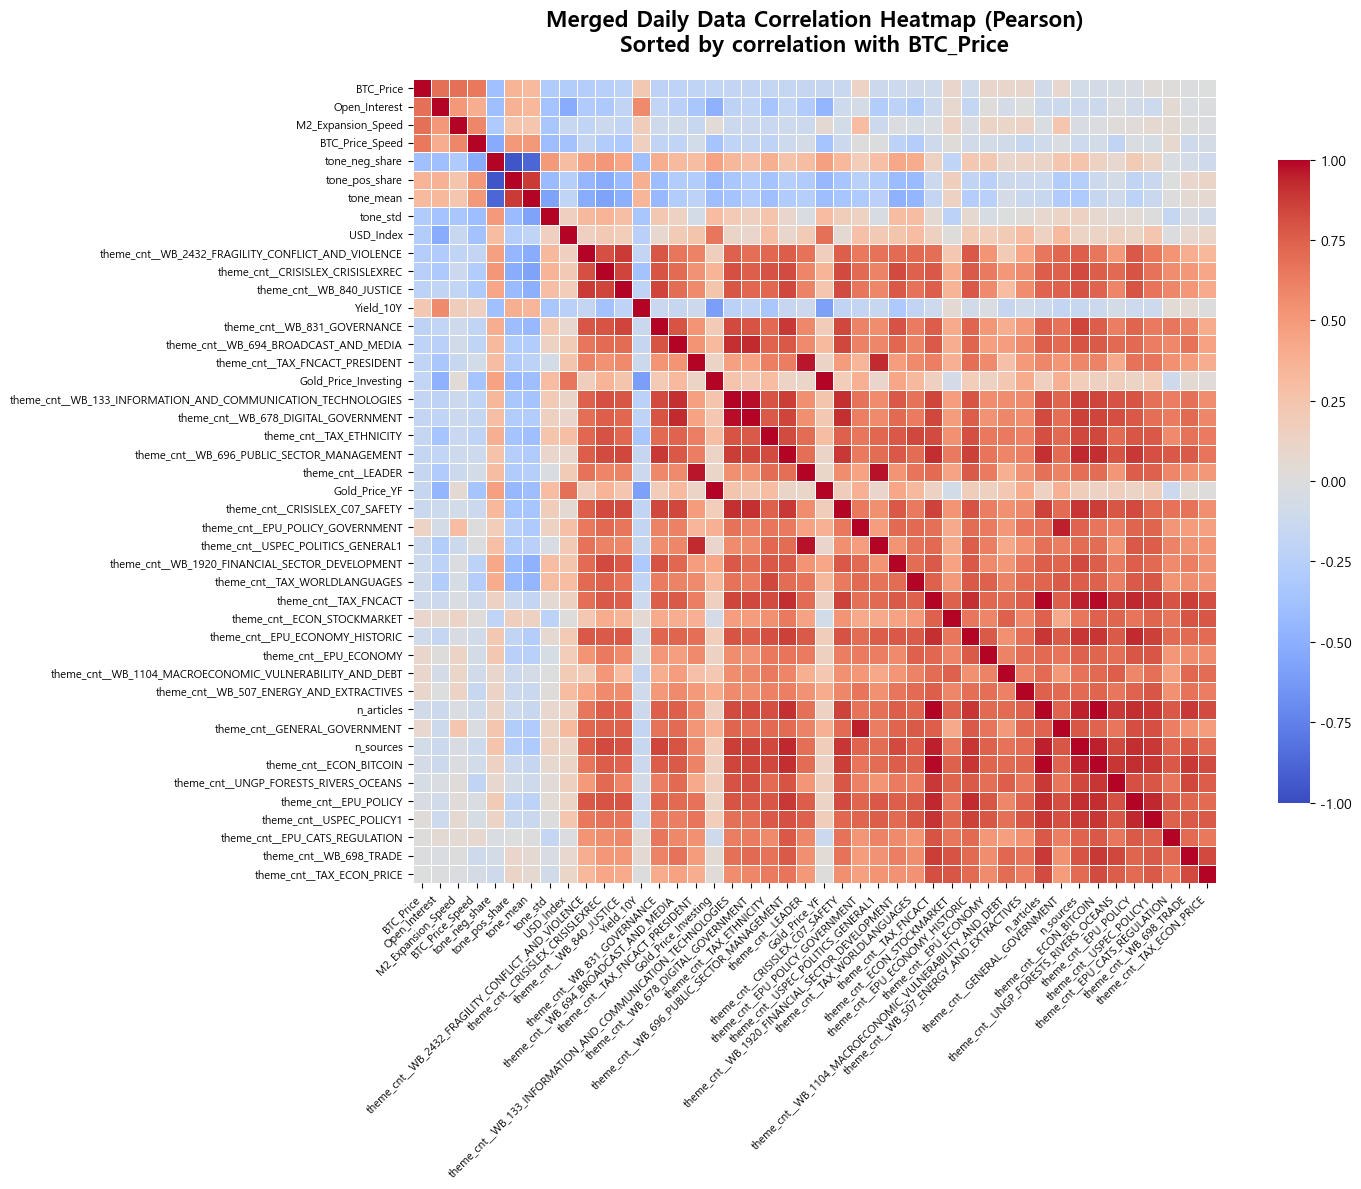


🎉 모든 분석이 완료되었습니다!

📁 생성된 파일: ./outputs\corr_heatmap.png


In [8]:
# ============================================================
# 셀 8: 상관관계 히트맵 생성 및 저장
# ============================================================

print("🎨 상관관계 히트맵 생성 중...\n")

# 컬럼 수에 따라 annot(숫자 표시) 여부 결정
num_cols = len(corr_matrix.columns)
show_annot = num_cols <= HEATMAP_ANNOT_THRESHOLD

if show_annot:
    print(f"   컬럼 수 {num_cols}개 → annot=True (상관계수 숫자 표시)")
else:
    print(f"   컬럼 수 {num_cols}개 → annot=False (숫자 표시 안 함, 가독성 우선)")

# Figure 생성
fig, ax = plt.subplots(figsize=HEATMAP_FIGSIZE)

# 히트맵 그리기
sns.heatmap(
    corr_matrix,
    annot=show_annot,           # 숫자 표시 여부
    fmt='.2f',                   # 숫자 포맷 (소수점 2자리)
    cmap='coolwarm',             # 색상: 파란색(음수) ~ 빨간색(양수)
    vmin=-1,                     # 최소값 -1로 고정
    vmax=1,                      # 최대값 1로 고정
    center=0,                    # 중심값 0
    square=True,                 # 정사각형 셀
    linewidths=0.5,              # 셀 경계선 두께
    cbar_kws={'shrink': 0.8},    # 컬러바 크기
    ax=ax
)

# 제목 설정
title_text = f'Merged Daily Data Correlation Heatmap ({CORR_METHOD.capitalize()})'
if btc_col:
    title_text += f'\nSorted by correlation with {btc_col}'

ax.set_title(
    title_text,
    fontsize=16,
    fontweight='bold',
    pad=20
)

# x축, y축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# 레이아웃 자동 조정 (레이블이 잘리지 않도록)
plt.tight_layout()

# ============================================================
# 이미지 파일로 저장
# ============================================================

# 출력 디렉토리 생성 (없으면 생성)
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)

# 이미지 저장
plt.savefig(
    output_path,
    dpi=300,              # 고해상도
    bbox_inches='tight',  # 여백 최소화
    facecolor='white'     # 배경색 흰색
)

print(f"\n✅ 히트맵 저장 완료: {output_path}")
print(f"   이미지 크기: {HEATMAP_FIGSIZE[0]} x {HEATMAP_FIGSIZE[1]} inches")
print(f"   해상도: 300 DPI")

# 화면에 표시
plt.show()

print("\n🎉 모든 분석이 완료되었습니다!")
print(f"\n📁 생성된 파일: {output_path}")

In [9]:
# ============================================================
# 셀 9: (선택사항) 추가 분석 - 상관관계 통계 요약
# ============================================================

print("📈 상관관계 통계 요약\n")
print("="*80)

if btc_col:
    # BTC_Price와의 상관계수 통계
    btc_corr_stats = corr_matrix[btc_col].drop(btc_col).describe()
    
    print(f"\n🎯 {btc_col}와의 상관계수 통계")
    print("-" * 80)
    print(f"{'항목':<20} {'값':>15}")
    print("-" * 80)
    print(f"{'총 변수 수':<20} {int(btc_corr_stats['count']):>15,}")
    print(f"{'평균':<20} {btc_corr_stats['mean']:>15.4f}")
    print(f"{'표준편차':<20} {btc_corr_stats['std']:>15.4f}")
    print(f"{'최소값 (음의 상관)':<20} {btc_corr_stats['min']:>15.4f}")
    print(f"{'25% 백분위':<20} {btc_corr_stats['25%']:>15.4f}")
    print(f"{'중앙값':<20} {btc_corr_stats['50%']:>15.4f}")
    print(f"{'75% 백분위':<20} {btc_corr_stats['75%']:>15.4f}")
    print(f"{'최대값 (양의 상관)':<20} {btc_corr_stats['max']:>15.4f}")
    
    # 강한 상관관계 변수 개수
    btc_corr_values = corr_matrix[btc_col].drop(btc_col)
    strong_positive = (btc_corr_values >= 0.7).sum()
    moderate_positive = ((btc_corr_values >= 0.4) & (btc_corr_values < 0.7)).sum()
    weak = ((btc_corr_values > -0.4) & (btc_corr_values < 0.4)).sum()
    moderate_negative = ((btc_corr_values <= -0.4) & (btc_corr_values > -0.7)).sum()
    strong_negative = (btc_corr_values <= -0.7).sum()
    
    print(f"\n📊 상관관계 강도별 변수 분포")
    print("-" * 80)
    print(f"{'강도':<30} {'변수 수':>15} {'비율':>15}")
    print("-" * 80)
    total_vars = len(btc_corr_values)
    print(f"{'강한 양의 상관 (≥ 0.7)':<30} {strong_positive:>15} {strong_positive/total_vars*100:>14.1f}%")
    print(f"{'중간 양의 상관 (0.4~0.7)':<30} {moderate_positive:>15} {moderate_positive/total_vars*100:>14.1f}%")
    print(f"{'약한 상관 (-0.4~0.4)':<30} {weak:>15} {weak/total_vars*100:>14.1f}%")
    print(f"{'중간 음의 상관 (-0.7~-0.4)':<30} {moderate_negative:>15} {moderate_negative/total_vars*100:>14.1f}%")
    print(f"{'강한 음의 상관 (≤ -0.7)':<30} {strong_negative:>15} {strong_negative/total_vars*100:>14.1f}%")

# 전체 상관행렬 통계
print(f"\n🌐 전체 상관행렬 통계")
print("-" * 80)

# 상관행렬에서 대각선 제외 (자기 자신과의 상관계수 1 제외)
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]

print(f"총 변수 쌍 수: {len(corr_values):,}")
print(f"평균 상관계수: {np.mean(corr_values):.4f}")
print(f"중앙값: {np.median(corr_values):.4f}")
print(f"표준편차: {np.std(corr_values):.4f}")
print(f"최소값: {np.min(corr_values):.4f}")
print(f"최대값: {np.max(corr_values):.4f}")

print("\n✅ 통계 요약 완료!")

📈 상관관계 통계 요약


🎯 BTC_Price와의 상관계수 통계
--------------------------------------------------------------------------------
항목                                 값
--------------------------------------------------------------------------------
총 변수 수                            43
평균                           -0.0232
표준편차                          0.2489
최소값 (음의 상관)                  -0.3858
25% 백분위                      -0.1748
중앙값                          -0.0982
75% 백분위                       0.0881
최대값 (양의 상관)                   0.6864

📊 상관관계 강도별 변수 분포
--------------------------------------------------------------------------------
강도                                        변수 수              비율
--------------------------------------------------------------------------------
강한 양의 상관 (≥ 0.7)                             0            0.0%
중간 양의 상관 (0.4~0.7)                           3            7.0%
약한 상관 (-0.4~0.4)                            40           93.0%
중간 음의 상관 (-0.7~-0.4)                

In [11]:
# ============================================================
# 셀 10: Lag 분석 대상 변수 정의
# ============================================================

print("⚙️ Lag 상관 분석 설정\n")
print("="*80)

# 타겟 변수 (종속변수)
target_col = 'BTC_Price'

# Lag 분석 대상 독립변수 리스트
lag_vars = ['tone_mean', 'tone_std', 'tone_neg_share', 'tone_pos_share']

# 최대 Lag 일수 (0~5일 선행)
max_lag = 5

# 상관계수 계산 방법
corr_method = 'pearson'

# 설정값 테이블 출력
print(f"{'항목':<30} {'값':<50}")
print("-"*80)
print(f"{'타겟 변수 (종속변수)':<30} {target_col:<50}")
print(f"{'Lag 분석 변수 (독립변수)':<30} {', '.join(lag_vars):<50}")
print(f"{'최대 Lag 일수':<30} {max_lag} (0~{max_lag}일 선행):<50")
print(f"{'상관계수 방법':<30} {corr_method:<50}")
print("="*80)

print("\n💡 Lag 해석:")
print(f"   - lag=0: 동일 날짜 상관관계")
print(f"   - lag=1: 변수가 BTC_Price보다 1일 선행 (변수의 전날 값 ↔ BTC_Price)")
print(f"   - lag=2: 변수가 BTC_Price보다 2일 선행 (변수의 전전날 값 ↔ BTC_Price)")
print(f"   - 일반적으로 lag가 클수록 과거 시점의 변수와 현재 BTC_Price 간 관계")

print("\n✅ Lag 분석 설정 완료!")


⚙️ Lag 상관 분석 설정

항목                             값                                                 
--------------------------------------------------------------------------------
타겟 변수 (종속변수)                   BTC_Price                                         
Lag 분석 변수 (독립변수)               tone_mean, tone_std, tone_neg_share, tone_pos_share
최대 Lag 일수                      5 (0~5일 선행):<50
상관계수 방법                        pearson                                           

💡 Lag 해석:
   - lag=0: 동일 날짜 상관관계
   - lag=1: 변수가 BTC_Price보다 1일 선행 (변수의 전날 값 ↔ BTC_Price)
   - lag=2: 변수가 BTC_Price보다 2일 선행 (변수의 전전날 값 ↔ BTC_Price)
   - 일반적으로 lag가 클수록 과거 시점의 변수와 현재 BTC_Price 간 관계

✅ Lag 분석 설정 완료!


In [12]:
# ============================================================
# 셀 11: Lag 생성 함수 정의
# ============================================================

def compute_lag_corr(df, target_col, var, max_lag, method='pearson'):
    """
    특정 변수와 타겟 변수 간의 Lag 상관관계를 계산하는 함수
    
    Args:
        df: pandas DataFrame (인덱스가 datetime)
        target_col: 타겟 변수명 (종속변수, 예: BTC_Price)
        var: Lag 분석 대상 변수명 (독립변수, 예: tone_mean)
        max_lag: 최대 Lag 일수 (0~max_lag)
        method: 상관계수 계산 방법 ('pearson' 또는 'spearman')
    
    Returns:
        DataFrame: lag, corr 컬럼을 가진 결과 테이블
    """
    results = []
    
    # lag = 0부터 max_lag까지 반복
    for lag in range(max_lag + 1):
        if lag == 0:
            # lag=0: 동일 날짜 상관관계
            var_lagged = df[var]
        else:
            # lag>0: 변수를 lag일만큼 shift (변수가 타겟보다 lag일 선행)
            var_lagged = df[var].shift(lag)
        
        # 타겟 변수와 lag된 변수를 하나의 DataFrame으로 결합
        temp_df = pd.DataFrame({
            'target': df[target_col],
            'var_lagged': var_lagged
        })
        
        # 결측치 제거 (lag로 인해 생긴 NaN 포함)
        temp_df = temp_df.dropna()
        
        # 상관계수 계산
        if len(temp_df) > 1:  # 최소 2개 이상의 데이터 필요
            corr_value = temp_df['target'].corr(temp_df['var_lagged'], method=method)
        else:
            corr_value = np.nan
        
        # 결과 저장
        results.append({
            'lag': lag,
            'corr': corr_value
        })
    
    # DataFrame으로 변환
    result_df = pd.DataFrame(results)
    
    return result_df


print("✅ Lag 상관 분석 함수 정의 완료!")
print("\n함수명: compute_lag_corr(df, target_col, var, max_lag, method='pearson')")
print("\n기능:")
print("   - 특정 변수의 0~max_lag일 선행 시 타겟 변수와의 상관관계 계산")
print("   - shift()를 사용하여 시계열 lag 적용")
print("   - 각 lag별 상관계수를 DataFrame으로 반환")


✅ Lag 상관 분석 함수 정의 완료!

함수명: compute_lag_corr(df, target_col, var, max_lag, method='pearson')

기능:
   - 특정 변수의 0~max_lag일 선행 시 타겟 변수와의 상관관계 계산
   - shift()를 사용하여 시계열 lag 적용
   - 각 lag별 상관계수를 DataFrame으로 반환


In [13]:
# ============================================================
# 셀 12: 변수별 Lag 상관 계산 + 결과 테이블 출력
# ============================================================

print("🔍 Lag 상관 분석 실행 중...\n")

# 타겟 변수가 데이터에 있는지 확인
if target_col not in df_clean.columns:
    print(f"❌ 타겟 변수 '{target_col}'를 찾을 수 없습니다.")
    print(f"사용 가능한 컬럼: {list(df_clean.columns[:10])}...")
    raise ValueError(f"'{target_col}' 컬럼이 존재하지 않습니다.")

# 각 변수에 대해 Lag 상관 계산
all_results = []

for var in lag_vars:
    if var not in df_clean.columns:
        print(f"⚠️  변수 '{var}'를 찾을 수 없습니다. 건너뜁니다.")
        continue
    
    print(f"   {var} 분석 중...")
    
    # Lag 상관 계산
    lag_result = compute_lag_corr(df_clean, target_col, var, max_lag, corr_method)
    
    # 변수명 추가
    lag_result['variable'] = var
    
    # 절대값 추가 (정렬용)
    lag_result['abs_corr'] = lag_result['corr'].abs()
    
    all_results.append(lag_result)

# 하나의 DataFrame으로 합치기
df_lag_corr = pd.concat(all_results, ignore_index=True)

# 컬럼 순서 재정렬
df_lag_corr = df_lag_corr[['variable', 'lag', 'corr', 'abs_corr']]

print(f"\n✅ Lag 상관 분석 완료! (총 {len(df_lag_corr)}개 lag-변수 조합)")

# ============================================================
# 변수별 최대 상관관계 요약
# ============================================================

print("\n" + "="*80)
print("📊 변수별 최대 Lag 상관관계 요약")
print("="*80)

summary = []
for var in lag_vars:
    if var not in df_lag_corr['variable'].values:
        continue
    
    var_data = df_lag_corr[df_lag_corr['variable'] == var]
    max_idx = var_data['abs_corr'].idxmax()
    max_row = var_data.loc[max_idx]
    
    summary.append({
        '변수명': var,
        '최대 상관 Lag': int(max_row['lag']),
        '상관계수': max_row['corr'],
        '절대값': max_row['abs_corr']
    })

df_summary = pd.DataFrame(summary)
display(df_summary)

# ============================================================
# 전체 상위 10개 lag-변수 조합 출력
# ============================================================

print("\n" + "="*80)
print("🎯 전체 상위 10개 Lag-변수 조합 (절대값 기준)")
print("="*80)

top10 = df_lag_corr.nlargest(10, 'abs_corr')

print(f"{'순위':<5} {'변수명':<25} {'Lag (일)':<10} {'상관계수':>12} {'절대값':>12}")
print("-"*80)

for i, (idx, row) in enumerate(top10.iterrows(), 1):
    print(f"{i:<5} {row['variable']:<25} {int(row['lag']):<10} {row['corr']:>12.4f} {row['abs_corr']:>12.4f}")

print("\n💡 해석:")
print("   - Lag 값이 클수록 변수가 BTC_Price보다 오래 전에 선행")
print("   - 높은 상관계수는 해당 Lag에서 강한 관계를 의미")
print("   - 음수 상관계수는 반대 방향 관계 (변수 증가 → BTC_Price 감소)")


🔍 Lag 상관 분석 실행 중...

   tone_mean 분석 중...
   tone_std 분석 중...
   tone_neg_share 분석 중...
   tone_pos_share 분석 중...

✅ Lag 상관 분석 완료! (총 24개 lag-변수 조합)

📊 변수별 최대 Lag 상관관계 요약


,변수명,최대 상관 Lag,상관계수,절대값
0,tone_mean,0,0.3131,0.3131
1,tone_std,0,-0.2961,0.2961
2,tone_neg_share,0,-0.3858,0.3858
3,tone_pos_share,0,0.3577,0.3577



🎯 전체 상위 10개 Lag-변수 조합 (절대값 기준)
순위    변수명                       Lag (일)            상관계수          절대값
--------------------------------------------------------------------------------
1     tone_neg_share            0               -0.3858       0.3858
2     tone_pos_share            0                0.3577       0.3577
3     tone_neg_share            1               -0.3204       0.3204
4     tone_neg_share            4               -0.3138       0.3138
5     tone_mean                 0                0.3131       0.3131
6     tone_neg_share            2               -0.3117       0.3117
7     tone_neg_share            3               -0.3000       0.3000
8     tone_pos_share            4                0.2985       0.2985
9     tone_std                  0               -0.2961       0.2961
10    tone_pos_share            3                0.2952       0.2952

💡 해석:
   - Lag 값이 클수록 변수가 BTC_Price보다 오래 전에 선행
   - 높은 상관계수는 해당 Lag에서 강한 관계를 의미
   - 음수 상관계수는 반대 방향 관계 (변수 증가 → BTC_Price 감소)


🎨 Lag 상관 라인 차트 생성 중...

✅ Lag 상관 라인 차트 생성 완료!


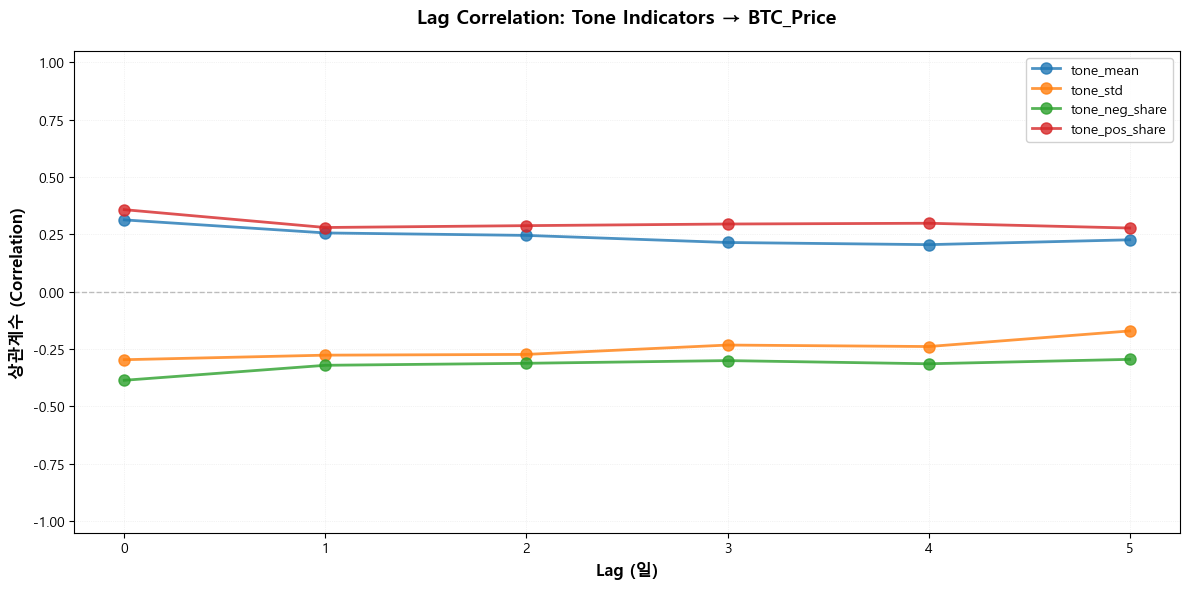


💡 차트 해석:
   - x축: Lag (0=동일날짜, 1=1일 선행, 2=2일 선행, ...)
   - y축: 상관계수 (1=강한 양의 관계, -1=강한 음의 관계, 0=관계 없음)
   - 각 선: tone 관련 변수별 Lag 상관관계 추이
   - 피크가 있는 Lag 지점 = 해당 변수가 가장 강한 영향력을 미치는 선행 일수


In [14]:
# ============================================================
# 셀 13: Lag 상관 결과 시각화 (라인 차트, 발표용)
# ============================================================

print("🎨 Lag 상관 라인 차트 생성 중...\n")

# Figure 생성
fig, ax = plt.subplots(figsize=(12, 6))

# 변수별로 라인 플롯
for var in lag_vars:
    if var not in df_lag_corr['variable'].values:
        continue
    
    var_data = df_lag_corr[df_lag_corr['variable'] == var].sort_values('lag')
    ax.plot(var_data['lag'], var_data['corr'], marker='o', linewidth=2, 
            markersize=8, label=var, alpha=0.8)

# y=0 기준선 표시
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# 축 레이블 및 제목
ax.set_xlabel('Lag (일)', fontsize=12, fontweight='bold')
ax.set_ylabel('상관계수 (Correlation)', fontsize=12, fontweight='bold')
ax.set_title('Lag Correlation: Tone Indicators → BTC_Price', 
             fontsize=14, fontweight='bold', pad=20)

# x축 정수로 설정
ax.set_xticks(range(max_lag + 1))

# 격자선
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# 범례 위치 조정
ax.legend(loc='best', fontsize=10, framealpha=0.9)

# y축 범위 설정 (-1 ~ 1)
ax.set_ylim(-1.05, 1.05)

# 레이아웃 조정
plt.tight_layout()

print("✅ Lag 상관 라인 차트 생성 완료!")
plt.show()

print("\n💡 차트 해석:")
print("   - x축: Lag (0=동일날짜, 1=1일 선행, 2=2일 선행, ...)")
print("   - y축: 상관계수 (1=강한 양의 관계, -1=강한 음의 관계, 0=관계 없음)")
print("   - 각 선: tone 관련 변수별 Lag 상관관계 추이")
print("   - 피크가 있는 Lag 지점 = 해당 변수가 가장 강한 영향력을 미치는 선행 일수")


🎨 Lag 상관 히트맵 생성 중...

✅ Lag 상관 히트맵 저장 완료!
   저장 경로: ./outputs\lag_corr_heatmap.png
   해상도: 300 DPI


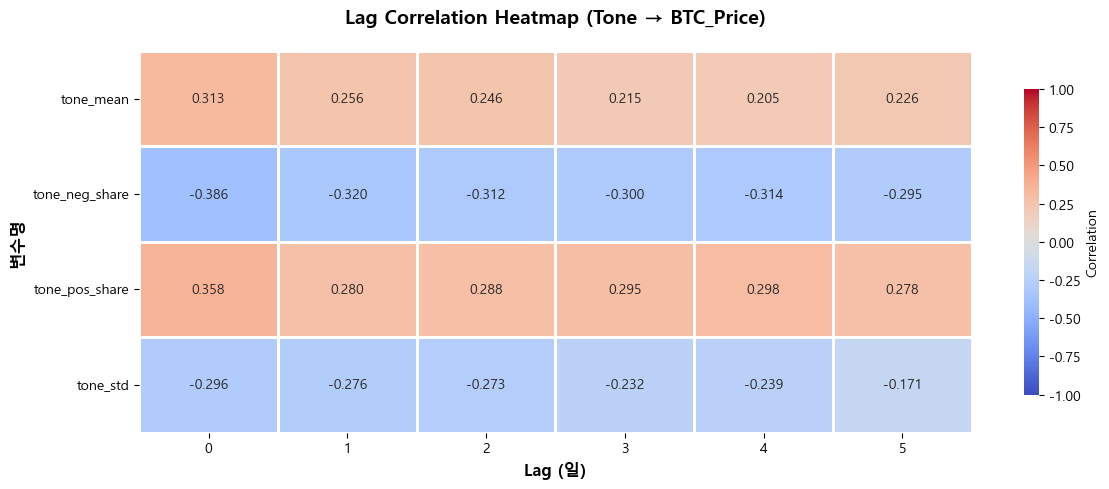


💡 히트맵 해석:
   - 가로축: Lag 일수 (0~5일)
   - 세로축: Tone 관련 변수
   - 색상: 빨간색=양의 상관, 파란색=음의 상관, 흰색=상관 없음
   - 각 셀의 숫자: 정확한 상관계수 값


In [15]:
# ============================================================
# 셀 14: Lag 상관 Heatmap (변수 × lag)
# ============================================================

print("🎨 Lag 상관 히트맵 생성 중...\n")

# Pivot 테이블 생성 (변수 × lag)
df_pivot = df_lag_corr.pivot(index='variable', columns='lag', values='corr')

# Figure 생성
fig, ax = plt.subplots(figsize=(12, 5))

# 히트맵 그리기
sns.heatmap(
    df_pivot,
    annot=True,              # 숫자 표시
    fmt='.3f',               # 소수점 3자리
    cmap='coolwarm',         # 색상: 파란색(음수) ~ 빨간색(양수)
    vmin=-1,                 # 최소값 -1로 고정
    vmax=1,                  # 최대값 1로 고정
    center=0,                # 중심값 0
    linewidths=1,            # 셀 경계선 두께
    linecolor='white',       # 셀 경계선 색상
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},  # 컬러바
    ax=ax
)

# 제목 설정
ax.set_title('Lag Correlation Heatmap (Tone → BTC_Price)', 
             fontsize=14, fontweight='bold', pad=20)

# 축 레이블
ax.set_xlabel('Lag (일)', fontsize=12, fontweight='bold')
ax.set_ylabel('변수명', fontsize=12, fontweight='bold')

# y축 레이블 회전
plt.yticks(rotation=0)

# 레이아웃 조정
plt.tight_layout()

# ============================================================
# 이미지 저장
# ============================================================

# 출력 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)
lag_heatmap_path = os.path.join(OUTPUT_DIR, 'lag_corr_heatmap.png')

# 이미지 저장
plt.savefig(
    lag_heatmap_path,
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

print(f"✅ Lag 상관 히트맵 저장 완료!")
print(f"   저장 경로: {lag_heatmap_path}")
print(f"   해상도: 300 DPI")

# 화면에 표시
plt.show()

print("\n💡 히트맵 해석:")
print("   - 가로축: Lag 일수 (0~5일)")
print("   - 세로축: Tone 관련 변수")
print("   - 색상: 빨간색=양의 상관, 파란색=음의 상관, 흰색=상관 없음")
print("   - 각 셀의 숫자: 정확한 상관계수 값")


In [16]:
# ============================================================
# 셀 15: 발표용 핵심 문장 자동 생성
# ============================================================

print("📝 발표용 핵심 해석 문장 자동 생성\n")
print("="*80)
print("🎯 변수별 최대 Lag 상관관계 해석")
print("="*80)
print()

# 변수별로 최대 상관관계 추출 및 문장 생성
for var in lag_vars:
    if var not in df_lag_corr['variable'].values:
        print(f"⚠️  {var}: 데이터 없음")
        continue
    
    # 해당 변수의 데이터 추출
    var_data = df_lag_corr[df_lag_corr['variable'] == var]
    
    # 절대값 기준 최대 상관관계 찾기
    max_idx = var_data['abs_corr'].idxmax()
    max_row = var_data.loc[max_idx]
    
    lag_val = int(max_row['lag'])
    corr_val = max_row['corr']
    
    # 상관관계 강도 판단
    abs_corr = abs(corr_val)
    if abs_corr >= 0.7:
        strength = "매우 강한"
    elif abs_corr >= 0.5:
        strength = "강한"
    elif abs_corr >= 0.3:
        strength = "중간"
    else:
        strength = "약한"
    
    # 방향 판단
    direction = "양의" if corr_val > 0 else "음의"
    
    # 시점 해석
    if lag_val == 0:
        timing = "동일 날짜"
    elif lag_val == 1:
        timing = f"{lag_val}일 선행"
    else:
        timing = f"{lag_val}일 선행"
    
    # 문장 생성 및 출력
    print(f"📌 {var}")
    print(f"   → BTC_Price 대비 {timing} 시 상관계수 {corr_val:.3f}로 최대값을 보였습니다.")
    print(f"   → 이는 {strength} {direction} 상관관계를 나타냅니다.")
    
    if lag_val > 0:
        print(f"   → 즉, {var}의 변화가 {lag_val}일 후 BTC_Price에 {'같은' if corr_val > 0 else '반대'} 방향으로 영향을 줄 가능성이 있습니다.")
    else:
        print(f"   → 즉, {var}와 BTC_Price가 동일 시점에 {'같은' if corr_val > 0 else '반대'} 방향으로 움직입니다.")
    
    print()

print("="*80)
print("✅ 발표용 핵심 해석 문장 생성 완료!")
print()
print("💡 활용 방법:")
print("   - 위 문장들을 발표 자료에 직접 활용")
print("   - 각 변수의 시차(lag) 효과를 명확히 설명")
print("   - 선행 지표로서의 가능성 제시")


📝 발표용 핵심 해석 문장 자동 생성

🎯 변수별 최대 Lag 상관관계 해석

📌 tone_mean
   → BTC_Price 대비 동일 날짜 시 상관계수 0.313로 최대값을 보였습니다.
   → 이는 중간 양의 상관관계를 나타냅니다.
   → 즉, tone_mean와 BTC_Price가 동일 시점에 같은 방향으로 움직입니다.

📌 tone_std
   → BTC_Price 대비 동일 날짜 시 상관계수 -0.296로 최대값을 보였습니다.
   → 이는 약한 음의 상관관계를 나타냅니다.
   → 즉, tone_std와 BTC_Price가 동일 시점에 반대 방향으로 움직입니다.

📌 tone_neg_share
   → BTC_Price 대비 동일 날짜 시 상관계수 -0.386로 최대값을 보였습니다.
   → 이는 중간 음의 상관관계를 나타냅니다.
   → 즉, tone_neg_share와 BTC_Price가 동일 시점에 반대 방향으로 움직입니다.

📌 tone_pos_share
   → BTC_Price 대비 동일 날짜 시 상관계수 0.358로 최대값을 보였습니다.
   → 이는 중간 양의 상관관계를 나타냅니다.
   → 즉, tone_pos_share와 BTC_Price가 동일 시점에 같은 방향으로 움직입니다.

✅ 발표용 핵심 해석 문장 생성 완료!

💡 활용 방법:
   - 위 문장들을 발표 자료에 직접 활용
   - 각 변수의 시차(lag) 효과를 명확히 설명
   - 선행 지표로서의 가능성 제시


In [18]:
# ============================================================
# 셀 16: 회귀 분석 설정 (타깃·통제·lag 후보)
# ============================================================

print("⚙️ 회귀 분석 설정\n")
print("="*80)

# 종속변수 (타깃)
target_col = 'BTC_Price'

# 통제변수 (시장 변수)
control_vars = ['Open_Interest', 'M2_Expansion_Speed', 'USD_Index', 'BTC_Price_Speed']

# Tone 관련 변수 (설명변수)
tone_vars = ['tone_mean', 'tone_std', 'tone_neg_share', 'tone_pos_share']

# 선택된 Lag 리스트 (0=동일날짜, 1=1일선행, 2=2일선행)
selected_lags = [0, 1, 2]

# 표준화 회귀 여부
standardize = True

# 설정값 테이블 출력
print(f"{'항목':<30} {'값':<50}")
print("-"*80)
print(f"{'종속변수 (타깃)':<30} {target_col:<50}")
print(f"{'통제변수 (시장변수)':<30} {', '.join(control_vars):<50}")
print(f"{'설명변수 (Tone 변수)':<30} {', '.join(tone_vars):<50}")
print(f"{'사용할 Lag 리스트':<30} {selected_lags} (0=동일날짜, 1~2=선행일수):<50")
print(f"{'표준화 회귀 여부':<30} {standardize:<50}")
print("="*80)

print("\n💡 회귀 분석 목적:")
print("   - 시장 변수(통제변수)를 통제한 상태에서")
print("   - Tone 변수의 lag 효과가 BTC_Price에 미치는 순수한 영향 파악")
print("   - 표준화 계수로 변수 간 상대적 영향력 비교")

print("\n✅ 회귀 분석 설정 완료!")


⚙️ 회귀 분석 설정

항목                             값                                                 
--------------------------------------------------------------------------------
종속변수 (타깃)                      BTC_Price                                         
통제변수 (시장변수)                    Open_Interest, M2_Expansion_Speed, USD_Index, BTC_Price_Speed
설명변수 (Tone 변수)                 tone_mean, tone_std, tone_neg_share, tone_pos_share
사용할 Lag 리스트                    [0, 1, 2] (0=동일날짜, 1~2=선행일수):<50
표준화 회귀 여부                      1                                                 

💡 회귀 분석 목적:
   - 시장 변수(통제변수)를 통제한 상태에서
   - Tone 변수의 lag 효과가 BTC_Price에 미치는 순수한 영향 파악
   - 표준화 계수로 변수 간 상대적 영향력 비교

✅ 회귀 분석 설정 완료!


In [19]:
# ============================================================
# 셀 17: Lag 변수 생성 (회귀용 데이터셋 구축)
# ============================================================

print("🔧 회귀 분석용 데이터셋 구축 중...\n")

# df_clean을 복사해서 회귀용 데이터프레임 생성
df_reg = df_clean.copy()

print(f"원본 데이터: {len(df_reg):,}개 행, {len(df_reg.columns)}개 컬럼")

# ============================================================
# Tone 변수에 대해 Lag 변수 생성
# ============================================================

lag_col_names = []

print(f"\n🔄 Lag 변수 생성 중...")
for var in tone_vars:
    if var not in df_reg.columns:
        print(f"⚠️  변수 '{var}'를 찾을 수 없습니다. 건너뜁니다.")
        continue
    
    for lag in selected_lags:
        if lag == 0:
            # lag=0: 동일 날짜, 원본 변수명 그대로 사용
            lag_col_name = var
        else:
            # lag>0: shift 적용, 변수명에 lag 붙임
            lag_col_name = f"{var}_lag{lag}"
            df_reg[lag_col_name] = df_reg[var].shift(lag)
            print(f"   생성: {lag_col_name} (변수가 BTC_Price보다 {lag}일 선행)")
        
        lag_col_names.append(lag_col_name)

print(f"\n✅ 총 {len(lag_col_names)}개 tone lag 변수 생성 완료")

# ============================================================
# 회귀 분석에 사용할 컬럼만 선택
# ============================================================

# 타겟 변수 확인
if target_col not in df_reg.columns:
    raise ValueError(f"❌ 타겟 변수 '{target_col}'를 찾을 수 없습니다.")

# 통제변수 확인
available_control_vars = [cv for cv in control_vars if cv in df_reg.columns]
missing_control_vars = [cv for cv in control_vars if cv not in df_reg.columns]

if missing_control_vars:
    print(f"\n⚠️  다음 통제변수를 찾을 수 없습니다: {missing_control_vars}")
    print(f"   사용 가능한 통제변수만 사용: {available_control_vars}")

# 최종 컬럼 리스트
selected_columns = [target_col] + available_control_vars + lag_col_names

# 데이터프레임 필터링
df_reg = df_reg[selected_columns]

print(f"\n📊 회귀용 데이터셋 컬럼 구성:")
print(f"   종속변수: {target_col}")
print(f"   통제변수: {available_control_vars}")
print(f"   Tone lag 변수: {len(lag_col_names)}개")

# ============================================================
# 결측치 제거
# ============================================================

print(f"\n🧹 결측치 제거 중...")
before_rows = len(df_reg)
df_reg = df_reg.dropna()
after_rows = len(df_reg)

print(f"   제거 전: {before_rows:,}개 행")
print(f"   제거 후: {after_rows:,}개 행")
print(f"   제거된 행: {before_rows - after_rows:,}개")

# ============================================================
# 최종 데이터셋 정보 출력
# ============================================================

print(f"\n" + "="*80)
print(f"✅ 회귀 분석용 데이터셋 구축 완료!")
print("="*80)
print(f"\n최종 shape: {df_reg.shape}")
print(f"   - 관측치 수: {df_reg.shape[0]:,}개")
print(f"   - 변수 수: {df_reg.shape[1]}개")

print(f"\n컬럼 리스트:")
for i, col in enumerate(df_reg.columns, 1):
    col_type = "종속변수" if col == target_col else \
               "통제변수" if col in available_control_vars else "Tone lag"
    print(f"   {i:2d}. {col:<30} ({col_type})")

print(f"\n💡 다음 단계: OLS 회귀 분석 실행")


🔧 회귀 분석용 데이터셋 구축 중...

원본 데이터: 61개 행, 44개 컬럼

🔄 Lag 변수 생성 중...
   생성: tone_mean_lag1 (변수가 BTC_Price보다 1일 선행)
   생성: tone_mean_lag2 (변수가 BTC_Price보다 2일 선행)
   생성: tone_std_lag1 (변수가 BTC_Price보다 1일 선행)
   생성: tone_std_lag2 (변수가 BTC_Price보다 2일 선행)
   생성: tone_neg_share_lag1 (변수가 BTC_Price보다 1일 선행)
   생성: tone_neg_share_lag2 (변수가 BTC_Price보다 2일 선행)
   생성: tone_pos_share_lag1 (변수가 BTC_Price보다 1일 선행)
   생성: tone_pos_share_lag2 (변수가 BTC_Price보다 2일 선행)

✅ 총 12개 tone lag 변수 생성 완료

📊 회귀용 데이터셋 컬럼 구성:
   종속변수: BTC_Price
   통제변수: ['Open_Interest', 'M2_Expansion_Speed', 'USD_Index', 'BTC_Price_Speed']
   Tone lag 변수: 12개

🧹 결측치 제거 중...
   제거 전: 61개 행
   제거 후: 59개 행
   제거된 행: 2개

✅ 회귀 분석용 데이터셋 구축 완료!

최종 shape: (59, 17)
   - 관측치 수: 59개
   - 변수 수: 17개

컬럼 리스트:
    1. BTC_Price                      (종속변수)
    2. Open_Interest                  (통제변수)
    3. M2_Expansion_Speed             (통제변수)
    4. USD_Index                      (통제변수)
    5. BTC_Price_Speed                (통제변수)
    6. tone_mean    

In [21]:
# ============================================================
# 셀 18: 표준화(선택) + OLS 회귀 실행
# ============================================================

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

print("📈 OLS 회귀 분석 실행 중...\n")
print("="*80)

# 종속변수(y)와 독립변수(X) 분리
y = df_reg[target_col]
X = df_reg.drop(columns=[target_col])

print(f"종속변수 (y): {target_col}")
print(f"독립변수 (X): {X.shape[1]}개 변수")

# ============================================================
# 표준화 처리 (선택적)
# ============================================================

if standardize:
    print(f"\n🔧 표준화 진행 중...")
    print(f"   - 설명변수만 표준화 (종속변수는 원본 유지)")
    print(f"   - StandardScaler 사용 (평균=0, 표준편차=1)")
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=X.columns
    )
    X_for_reg = X_scaled
    print(f"   ✅ 표준화 완료!")
else:
    print(f"\n⚠️  표준화 미적용 (원본 스케일 사용)")
    X_for_reg = X

# ============================================================
# 상수항 추가
# ============================================================

X_for_reg = sm.add_constant(X_for_reg)
print(f"\n✅ 상수항(constant) 추가 완료")

# ============================================================
# OLS 회귀 모델 적합
# ============================================================

print(f"\n📊 OLS 회귀 모델 적합 중...")
model = sm.OLS(y, X_for_reg)
results = model.fit()

print(f"✅ 회귀 분석 완료!")

# ============================================================
# 회귀 결과 Summary 출력
# ============================================================

print(f"\n" + "="*80)
print(f"📋 OLS 회귀 분석 결과 (전체 Summary)")
print("="*80)
print(results.summary())

# ============================================================
# 주요 지표 별도 출력
# ============================================================

print(f"\n" + "="*80)
print(f"🎯 주요 모델 성능 지표")
print("="*80)
print(f"{'지표':<30} {'값':>15}")
print("-"*80)
print(f"{'R-squared':<30} {results.rsquared:>15.4f}")
print(f"{'Adj. R-squared':<30} {results.rsquared_adj:>15.4f}")
print(f"{'F-statistic':<30} {results.fvalue:>15.2f}")
print(f"{'Prob (F-statistic)':<30} {results.f_pvalue:>15.6f}")
print(f"{'AIC':<30} {results.aic:>15.2f}")
print(f"{'BIC':<30} {results.bic:>15.2f}")
print(f"{'관측치 수':<30} {int(results.nobs):>15,}")
print("="*80)

print("\n💡 해석:")
print(f"   - R-squared: 모델이 종속변수 분산의 {results.rsquared*100:.2f}% 설명")
print(f"   - Adj. R-squared: 변수 개수를 고려한 설명력 {results.rsquared_adj*100:.2f}%")
if results.f_pvalue < 0.05:
    print(f"   - F-검정: 모델 전체적으로 통계적으로 유의미함 (p < 0.05)")
else:
    print(f"   - F-검정: 모델 전체적으로 통계적으로 유의미하지 않음 (p ≥ 0.05)")


📈 OLS 회귀 분석 실행 중...

종속변수 (y): BTC_Price
독립변수 (X): 16개 변수

🔧 표준화 진행 중...
   - 설명변수만 표준화 (종속변수는 원본 유지)
   - StandardScaler 사용 (평균=0, 표준편차=1)
   ✅ 표준화 완료!

✅ 상수항(constant) 추가 완료

📊 OLS 회귀 모델 적합 중...
✅ 회귀 분석 완료!

📋 OLS 회귀 분석 결과 (전체 Summary)
                            OLS Regression Results                            
Dep. Variable:              BTC_Price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     7.847
Date:                Tue, 03 Feb 2026   Prob (F-statistic):           4.22e-08
Time:                        16:02:41   Log-Likelihood:                -538.15
No. Observations:                  59   AIC:                             1110.
Df Residuals:                      42   BIC:                             1146.
Df Model:                          16                                         
Covariance Type:            nonrobust              

In [22]:
# ============================================================
# 셀 19: 계수 정리 (표준화 계수 + 유의성)
# ============================================================

print("📊 회귀 계수 정리 중...\n")

# 회귀 계수, p-value 추출
coef_df = pd.DataFrame({
    'variable': results.params.index,
    'coef': results.params.values,
    'p_value': results.pvalues.values,
    'std_err': results.bse.values
})

# 상수항 제외
coef_df = coef_df[coef_df['variable'] != 'const']

# 절대값 컬럼 추가 (정렬용)
coef_df['abs_coef'] = coef_df['coef'].abs()

# 유의성 표시 추가
coef_df['significance'] = coef_df['p_value'].apply(
    lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
)

# 절대값 기준 내림차순 정렬
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)

# ============================================================
# 전체 변수 상위 10개 출력
# ============================================================

print("="*80)
print("🎯 회귀 계수 상위 10개 변수 (절대값 기준)")
print("="*80)
print(f"{'순위':<5} {'변수명':<30} {'계수':>12} {'P-value':>12} {'유의성':<5}")
print("-"*80)

for i, row in coef_df.head(10).iterrows():
    print(f"{i+1:<5} {row['variable']:<30} {row['coef']:>12.4f} {row['p_value']:>12.4f} {row['significance']:<5}")

print("-"*80)
print("유의수준: *** p<0.001, ** p<0.01, * p<0.05")

# ============================================================
# 유의한 변수만 필터링
# ============================================================

significant_vars = coef_df[coef_df['p_value'] < 0.05]

print(f"\n📌 통계적으로 유의한 변수 (p < 0.05): {len(significant_vars)}개")
if len(significant_vars) > 0:
    print(f"\n{'변수명':<30} {'계수':>12} {'P-value':>12} {'유의성':<5}")
    print("-"*80)
    for _, row in significant_vars.iterrows():
        print(f"{row['variable']:<30} {row['coef']:>12.4f} {row['p_value']:>12.4f} {row['significance']:<5}")

# ============================================================
# Tone 계열 변수만 필터링
# ============================================================

print("\n" + "="*80)
print("🎨 Tone 계열 변수만 추출")
print("="*80)

tone_coef_df = coef_df[coef_df['variable'].str.contains('tone', case=False, na=False)]

if len(tone_coef_df) > 0:
    print(f"\n총 {len(tone_coef_df)}개 tone 변수")
    print(f"\n{'순위':<5} {'변수명':<30} {'계수':>12} {'P-value':>12} {'유의성':<5}")
    print("-"*80)
    
    for i, row in tone_coef_df.iterrows():
        print(f"{i+1:<5} {row['variable']:<30} {row['coef']:>12.4f} {row['p_value']:>12.4f} {row['significance']:<5}")
    
    # Tone 변수 중 유의한 것
    tone_significant = tone_coef_df[tone_coef_df['p_value'] < 0.05]
    print(f"\n💡 Tone 변수 중 통계적으로 유의한 변수: {len(tone_significant)}개")
else:
    print("⚠️  Tone 계열 변수를 찾을 수 없습니다.")

print("\n✅ 계수 정리 완료!")


📊 회귀 계수 정리 중...

🎯 회귀 계수 상위 10개 변수 (절대값 기준)
순위    변수명                                      계수      P-value 유의성  
--------------------------------------------------------------------------------
1     tone_pos_share_lag1              -2435.4169       0.0901      
2     Open_Interest                     2331.2356       0.0002 ***  
3     BTC_Price_Speed                   1937.1180       0.0013 **   
4     tone_neg_share_lag1              -1713.8998       0.2331      
5     M2_Expansion_Speed                1328.1354       0.0238 *    
6     tone_pos_share_lag2              -1142.5388       0.4121      
7     tone_mean_lag2                     654.8169       0.4639      
8     tone_mean_lag1                     583.9440       0.5543      
9     USD_Index                          507.4816       0.3590      
10    tone_std_lag1                      493.7219       0.3372      
--------------------------------------------------------------------------------
유의수준: *** p<0.001, ** p<0.01, * p<0

🎨 Tone 변수 회귀 계수 바차트 생성 중...

✅ Tone 변수 계수 바차트 생성 완료!


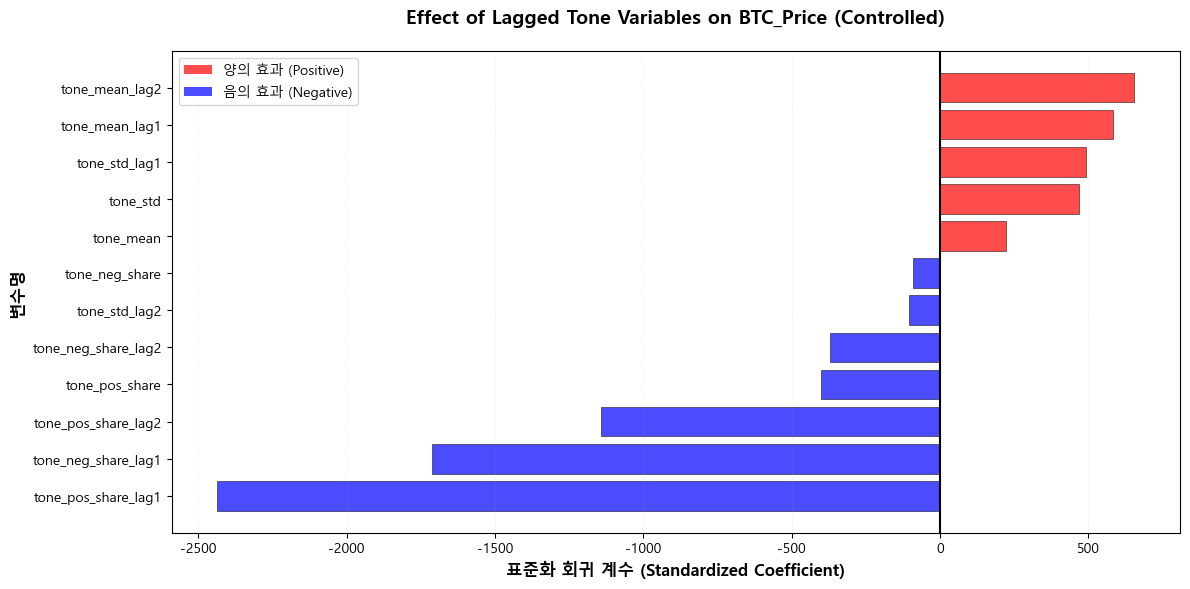


💡 차트 해석:
   - 빨간색: Tone 변수가 BTC_Price에 양의 영향 (증가 → 증가)
   - 파란색: Tone 변수가 BTC_Price에 음의 영향 (증가 → 감소)
   - 별표(*, **, ***): 통계적 유의성 (많을수록 강함)
   - 바의 길이: 영향력의 크기 (표준화 계수)


In [23]:
# ============================================================
# 셀 20: 발표용 계수 바차트 (tone 변수만)
# ============================================================

print("🎨 Tone 변수 회귀 계수 바차트 생성 중...\n")

if len(tone_coef_df) == 0:
    print("⚠️  Tone 변수가 없어 차트를 생성할 수 없습니다.")
else:
    # Figure 생성
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 변수명을 인덱스로, 계수를 값으로
    tone_coef_sorted = tone_coef_df.sort_values('coef', ascending=True)
    
    # 색상 지정 (양수=빨강, 음수=파랑)
    colors = ['red' if c > 0 else 'blue' for c in tone_coef_sorted['coef']]
    
    # 바차트 그리기
    bars = ax.barh(
        tone_coef_sorted['variable'], 
        tone_coef_sorted['coef'],
        color=colors,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )
    
    # y=0 기준선 표시
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    
    # 유의성 표시 (별표)
    for i, (idx, row) in enumerate(tone_coef_sorted.iterrows()):
        if row['p_value'] < 0.05:
            # 유의한 변수에 별표 표시
            x_pos = row['coef'] + (0.02 if row['coef'] > 0 else -0.02)
            ax.text(x_pos, i, row['significance'], 
                   va='center', ha='left' if row['coef'] > 0 else 'right',
                   fontsize=12, fontweight='bold', color='black')
    
    # 축 레이블 및 제목
    ax.set_xlabel('표준화 회귀 계수 (Standardized Coefficient)', fontsize=12, fontweight='bold')
    ax.set_ylabel('변수명', fontsize=12, fontweight='bold')
    ax.set_title('Effect of Lagged Tone Variables on BTC_Price (Controlled)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # 격자선
    ax.grid(True, axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
    
    # 범례 추가
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.7, label='양의 효과 (Positive)'),
        Patch(facecolor='blue', alpha=0.7, label='음의 효과 (Negative)')
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    print("✅ Tone 변수 계수 바차트 생성 완료!")
    plt.show()
    
    print("\n💡 차트 해석:")
    print("   - 빨간색: Tone 변수가 BTC_Price에 양의 영향 (증가 → 증가)")
    print("   - 파란색: Tone 변수가 BTC_Price에 음의 영향 (증가 → 감소)")
    print("   - 별표(*, **, ***): 통계적 유의성 (많을수록 강함)")
    print("   - 바의 길이: 영향력의 크기 (표준화 계수)")


In [24]:
# ============================================================
# 셀 21: 모델 비교 (tone 포함 vs 미포함)
# ============================================================

print("📊 모델 비교: Tone 변수 포함 vs 미포함\n")
print("="*80)

# ============================================================
# 모델 1: Tone 변수 제외 (통제변수만)
# ============================================================

print("🔧 모델 1 구축 중: 통제변수만 사용...")

# 통제변수만 선택
X_control = df_reg[available_control_vars]

# 표준화 (standardize=True인 경우)
if standardize:
    scaler_control = StandardScaler()
    X_control_scaled = pd.DataFrame(
        scaler_control.fit_transform(X_control),
        index=X_control.index,
        columns=X_control.columns
    )
    X_control_for_reg = X_control_scaled
else:
    X_control_for_reg = X_control

# 상수항 추가
X_control_for_reg = sm.add_constant(X_control_for_reg)

# OLS 회귀
model_control = sm.OLS(y, X_control_for_reg)
results_control = model_control.fit()

print("✅ 모델 1 완료 (통제변수만)")

# ============================================================
# 모델 2: Tone 변수 포함 (전체 모델) - 이미 실행됨
# ============================================================

print("✅ 모델 2 완료 (통제변수 + Tone lag 변수)")

# ============================================================
# 모델 비교 테이블 생성
# ============================================================

comparison_data = {
    '모델명': [
        '모델 1: 통제변수만',
        '모델 2: 통제변수 + Tone'
    ],
    'R-squared': [
        results_control.rsquared,
        results.rsquared
    ],
    'Adj. R-squared': [
        results_control.rsquared_adj,
        results.rsquared_adj
    ],
    'AIC': [
        results_control.aic,
        results.aic
    ],
    'BIC': [
        results_control.bic,
        results.bic
    ],
    '변수 개수': [
        results_control.df_model,
        results.df_model
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("📈 모델 성능 비교")
print("="*80)
display(df_comparison)

# ============================================================
# 설명력 개선도 계산
# ============================================================

r2_improvement = results.rsquared - results_control.rsquared
adj_r2_improvement = results.rsquared_adj - results_control.rsquared_adj
r2_improvement_pct = (r2_improvement / results_control.rsquared) * 100

print("\n" + "="*80)
print("🎯 Tone 변수 추가 효과")
print("="*80)

print(f"\n📊 설명력 개선:")
print(f"   - R-squared 증가: {r2_improvement:.4f} ({r2_improvement*100:.2f}%p 증가)")
print(f"   - Adj. R-squared 증가: {adj_r2_improvement:.4f} ({adj_r2_improvement*100:.2f}%p 증가)")
print(f"   - 상대적 개선율: {r2_improvement_pct:.2f}%")

print(f"\n📉 정보 기준 (Information Criteria):")
aic_improvement = results_control.aic - results.aic
bic_improvement = results_control.bic - results.bic
print(f"   - AIC 변화: {aic_improvement:.2f} ({'개선' if aic_improvement > 0 else '악화'})")
print(f"   - BIC 변화: {bic_improvement:.2f} ({'개선' if bic_improvement > 0 else '악화'})")

# ============================================================
# 자동 요약 문장 생성
# ============================================================

print("\n" + "="*80)
print("📝 발표용 요약 문장")
print("="*80)

summary_text = f"""
시장 변수(통제변수)만 사용한 모델의 R-squared는 {results_control.rsquared:.4f}였으나,
Tone 관련 lag 변수를 추가한 결과 R-squared가 {results.rsquared:.4f}로 증가하여
설명력이 {r2_improvement*100:.2f}%p 개선되었습니다.

이는 Tone 변수가 시장 변수를 통제한 이후에도 BTC_Price의 변동성을
추가적으로 설명할 수 있음을 시사합니다.
"""

if adj_r2_improvement > 0.01:
    summary_text += f"\n변수 개수를 고려한 Adj. R-squared 역시 {adj_r2_improvement*100:.2f}%p 개선되어,\nTone 변수의 설명력 추가가 통계적으로 의미 있음을 보여줍니다."
else:
    summary_text += f"\n다만 Adj. R-squared 개선폭이 {adj_r2_improvement*100:.2f}%p로 작아,\n변수 개수 증가 대비 설명력 증가가 제한적일 수 있습니다."

print(summary_text)

print("\n✅ 모델 비교 완료!")


📊 모델 비교: Tone 변수 포함 vs 미포함

🔧 모델 1 구축 중: 통제변수만 사용...
✅ 모델 1 완료 (통제변수만)
✅ 모델 2 완료 (통제변수 + Tone lag 변수)

📈 모델 성능 비교


,모델명,R-squared,Adj. R-squared,AIC,BIC,변수 개수
0,모델 1: 통제변수만,0.7109,0.6894,1094.7213,1105.1090,4.0000
1,모델 2: 통제변수 + Tone,0.7493,0.6538,1110.2971,1145.6153,16.0000



🎯 Tone 변수 추가 효과

📊 설명력 개선:
   - R-squared 증가: 0.0385 (3.85%p 증가)
   - Adj. R-squared 증가: -0.0356 (-3.56%p 증가)
   - 상대적 개선율: 5.41%

📉 정보 기준 (Information Criteria):
   - AIC 변화: -15.58 (악화)
   - BIC 변화: -40.51 (악화)

📝 발표용 요약 문장

시장 변수(통제변수)만 사용한 모델의 R-squared는 0.7109였으나,
Tone 관련 lag 변수를 추가한 결과 R-squared가 0.7493로 증가하여
설명력이 3.85%p 개선되었습니다.

이는 Tone 변수가 시장 변수를 통제한 이후에도 BTC_Price의 변동성을
추가적으로 설명할 수 있음을 시사합니다.

다만 Adj. R-squared 개선폭이 -3.56%p로 작아,
변수 개수 증가 대비 설명력 증가가 제한적일 수 있습니다.

✅ 모델 비교 완료!


In [25]:
# ============================================================
# 셀 22: 발표용 자동 해석 문장 생성
# ============================================================

print("📝 발표용 회귀 결과 해석 문장 자동 생성\n")
print("="*80)
print("🎯 Tone 변수별 회귀 결과 해석")
print("="*80)
print()

if len(tone_coef_df) == 0:
    print("⚠️  Tone 변수가 없어 해석 문장을 생성할 수 없습니다.")
else:
    for _, row in tone_coef_df.iterrows():
        var_name = row['variable']
        coef = row['coef']
        p_value = row['p_value']
        
        # 변수명에서 lag 추출
        if '_lag' in var_name:
            base_name = var_name.split('_lag')[0]
            lag_num = var_name.split('_lag')[1]
        else:
            base_name = var_name
            lag_num = '0'
        
        # 영향 방향 판단
        if coef > 0:
            direction = "양(+)의"
            effect_desc = "증가할 때 BTC_Price도 증가"
        else:
            direction = "음(-)의"
            effect_desc = "증가할 때 BTC_Price는 감소"
        
        # 유의성 판단
        if p_value < 0.001:
            significance = "매우 강하게 유의"
            sig_level = "p < 0.001"
        elif p_value < 0.01:
            significance = "강하게 유의"
            sig_level = "p < 0.01"
        elif p_value < 0.05:
            significance = "통계적으로 유의"
            sig_level = "p < 0.05"
        else:
            significance = "통계적으로 유의하지 않음"
            sig_level = f"p = {p_value:.3f}"
        
        # 계수 크기 해석
        abs_coef = abs(coef)
        if abs_coef >= 0.5:
            strength = "강한"
        elif abs_coef >= 0.3:
            strength = "중간 정도의"
        elif abs_coef >= 0.1:
            strength = "약한"
        else:
            strength = "매우 약한"
        
        # 시점 해석
        if lag_num == '0':
            timing = "동일 날짜"
        else:
            timing = f"{lag_num}일 선행"
        
        # 문장 생성
        print(f"📌 {base_name} ({timing})")
        print(f"   시장 변수들을 통제한 이후에도, {base_name}({timing})는")
        print(f"   BTC_Price에 {direction} 영향을 보였으며 (β = {coef:.3f}, {sig_level}),")
        print(f"   이는 {significance}했습니다.")
        print(f"   → 즉, {base_name}가 {effect_desc}하는 경향을 보입니다.")
        print(f"   → 영향력 크기: {strength} 수준 (표준화 계수 기준)")
        
        if p_value < 0.05 and lag_num != '0':
            print(f"   ✨ 특히 {lag_num}일 선행 효과가 통계적으로 유의하여,")
            print(f"      {base_name}가 BTC_Price의 선행 지표로 활용될 가능성을 시사합니다.")
        
        print()

# ============================================================
# 전체 요약 문장
# ============================================================

print("="*80)
print("📊 전체 Tone 변수 효과 종합 요약")
print("="*80)
print()

# 유의한 tone 변수 개수
tone_significant = tone_coef_df[tone_coef_df['p_value'] < 0.05]
num_significant = len(tone_significant)
num_total = len(tone_coef_df)

print(f"총 {num_total}개의 Tone lag 변수 중 {num_significant}개가 통계적으로 유의했습니다.")

if num_significant > 0:
    print(f"\n이는 시장 변수(Open Interest, M2, USD Index 등)를 통제한 이후에도")
    print(f"Tone 관련 변수들이 BTC 가격 변동을 추가적으로 설명할 수 있음을 의미합니다.")
    
    # 가장 영향력이 큰 변수
    max_impact_var = tone_coef_df.loc[tone_coef_df['abs_coef'].idxmax()]
    print(f"\n가장 영향력이 큰 변수는 '{max_impact_var['variable']}'로,")
    print(f"표준화 계수가 {max_impact_var['coef']:.3f}이며 {'유의' if max_impact_var['p_value'] < 0.05 else '비유의'}합니다.")
    
    # 양의 영향 vs 음의 영향
    num_positive = len(tone_coef_df[tone_coef_df['coef'] > 0])
    num_negative = len(tone_coef_df[tone_coef_df['coef'] < 0])
    print(f"\n방향성: 양의 영향 {num_positive}개, 음의 영향 {num_negative}개")
else:
    print(f"\n다만 통계적으로 유의한 Tone 변수가 없어,")
    print(f"Tone 변수의 설명력이 제한적일 수 있습니다.")

print("\n" + "="*80)
print("✅ 발표용 해석 문장 생성 완료!")
print("\n💡 위 문장들을 발표 자료에 직접 활용할 수 있습니다.")


📝 발표용 회귀 결과 해석 문장 자동 생성

🎯 Tone 변수별 회귀 결과 해석

📌 tone_pos_share (1일 선행)
   시장 변수들을 통제한 이후에도, tone_pos_share(1일 선행)는
   BTC_Price에 음(-)의 영향을 보였으며 (β = -2435.417, p = 0.090),
   이는 통계적으로 유의하지 않음했습니다.
   → 즉, tone_pos_share가 증가할 때 BTC_Price는 감소하는 경향을 보입니다.
   → 영향력 크기: 강한 수준 (표준화 계수 기준)

📌 tone_neg_share (1일 선행)
   시장 변수들을 통제한 이후에도, tone_neg_share(1일 선행)는
   BTC_Price에 음(-)의 영향을 보였으며 (β = -1713.900, p = 0.233),
   이는 통계적으로 유의하지 않음했습니다.
   → 즉, tone_neg_share가 증가할 때 BTC_Price는 감소하는 경향을 보입니다.
   → 영향력 크기: 강한 수준 (표준화 계수 기준)

📌 tone_pos_share (2일 선행)
   시장 변수들을 통제한 이후에도, tone_pos_share(2일 선행)는
   BTC_Price에 음(-)의 영향을 보였으며 (β = -1142.539, p = 0.412),
   이는 통계적으로 유의하지 않음했습니다.
   → 즉, tone_pos_share가 증가할 때 BTC_Price는 감소하는 경향을 보입니다.
   → 영향력 크기: 강한 수준 (표준화 계수 기준)

📌 tone_mean (2일 선행)
   시장 변수들을 통제한 이후에도, tone_mean(2일 선행)는
   BTC_Price에 양(+)의 영향을 보였으며 (β = 654.817, p = 0.464),
   이는 통계적으로 유의하지 않음했습니다.
   → 즉, tone_mean가 증가할 때 BTC_Price도 증가하는 경향을 보입니다.
   → 영향력 크기: 강한 수준 (표준화 계수 기준)

📌 tone_mean (1일

In [26]:
# ============================================================
# 셀 23: 오버랩 시계열 그래프 설정값 정의
# ============================================================

print("⚙️ 오버랩 시계열 그래프 설정\n")
print("="*80)

# 날짜 컬럼 (인덱스에 이미 설정되어 있으면 'date')
date_col = 'date'

# 가격 컬럼 (BTC 가격)
price_col = 'BTC_Price'

# Tone 관련 컬럼 리스트
tone_cols = ['tone_mean', 'tone_std', 'tone_neg_share', 'tone_pos_share']

# 정규화 방법
# 'zscore': z-score 정규화 (평균=0, 표준편차=1)
# 'minmax': min-max 정규화 (0~1 범위)
# 'none': 정규화 없이 원본 값 사용
normalize = 'zscore'

# 이동평균 윈도우 크기 (스무딩)
# 1: 스무딩 없음 (원본 데이터)
# 3: 3일 이동평균
# 7: 7일 이동평균
smooth_window = 3

# 출력 디렉토리
output_dir = './outputs'

# 설정값 요약 출력
print(f"{'항목':<30} {'값':<50}")
print("-"*80)
print(f"{'날짜 컬럼':<30} {date_col:<50}")
print(f"{'가격 컬럼 (BTC)':<30} {price_col:<50}")
print(f"{'Tone 지표 컬럼':<30} {', '.join(tone_cols):<50}")
print(f"{'정규화 방법':<30} {normalize:<50}")
print(f"{'이동평균 윈도우':<30} {smooth_window}일 {'(스무딩 적용)' if smooth_window > 1 else '(원본 사용)'}:<50")
print(f"{'출력 디렉토리':<30} {output_dir:<50}")
print("="*80)

print("\n💡 그래프 목적:")
print("   - BTC_Price와 Tone 지표들의 시계열 변화를 한 눈에 비교")
print("   - 정규화를 통해 스케일이 다른 변수들을 동일 축에 표시")
print("   - 시각적으로 선행/동행 패턴 파악")

print("\n✅ 오버랩 시계열 그래프 설정 완료!")


⚙️ 오버랩 시계열 그래프 설정

항목                             값                                                 
--------------------------------------------------------------------------------
날짜 컬럼                          date                                              
가격 컬럼 (BTC)                    BTC_Price                                         
Tone 지표 컬럼                     tone_mean, tone_std, tone_neg_share, tone_pos_share
정규화 방법                         zscore                                            
이동평균 윈도우                       3일 (스무딩 적용):<50
출력 디렉토리                        ./outputs                                         

💡 그래프 목적:
   - BTC_Price와 Tone 지표들의 시계열 변화를 한 눈에 비교
   - 정규화를 통해 스케일이 다른 변수들을 동일 축에 표시
   - 시각적으로 선행/동행 패턴 파악

✅ 오버랩 시계열 그래프 설정 완료!


In [27]:
# ============================================================
# 셀 24: 날짜 정렬 + 필요한 컬럼만 준비 + 결측 처리
# ============================================================

print("📊 플롯용 데이터 준비 중...\n")

# 필요한 컬럼 확인
required_cols = [price_col] + tone_cols

missing_cols = [col for col in required_cols if col not in df_merged.columns]
if missing_cols:
    print(f"❌ 다음 컬럼을 찾을 수 없습니다: {missing_cols}")
    print(f"사용 가능한 컬럼: {list(df_merged.columns[:10])}...")
    raise ValueError(f"필수 컬럼이 누락되었습니다: {missing_cols}")

# 필요한 컬럼만 선택
df_plot = df_merged[required_cols].copy()

print(f"✅ 필요한 컬럼 선택 완료")
print(f"   선택된 컬럼: {list(df_plot.columns)}")

# ============================================================
# 날짜 인덱스 확인 및 정렬
# ============================================================

# 이미 date 인덱스가 있는지 확인
if df_plot.index.name == date_col or isinstance(df_plot.index, pd.DatetimeIndex):
    print(f"\n✅ 날짜 인덱스 확인: '{df_plot.index.name}'")
    # datetime 타입으로 변환 (필요시)
    if not isinstance(df_plot.index, pd.DatetimeIndex):
        df_plot.index = pd.to_datetime(df_plot.index)
else:
    # 날짜 컬럼이 별도로 있는 경우
    if date_col in df_merged.columns:
        df_plot.index = pd.to_datetime(df_merged[date_col])
        df_plot.index.name = date_col
        print(f"\n✅ 날짜 컬럼을 인덱스로 설정: '{date_col}'")

# 날짜 순으로 정렬
df_plot = df_plot.sort_index()
print(f"✅ 날짜 순 정렬 완료")

# ============================================================
# 결측치 처리
# ============================================================

missing_before = df_plot.isnull().sum().sum()
print(f"\n🧹 결측치 처리 중...")
print(f"   처리 전 결측치: {missing_before:,}개")

# 기본: dropna 처리
df_plot = df_plot.dropna()

# 대안: Forward Fill (주석 처리)
# df_plot = df_plot.ffill()  # 이전 값으로 채우기
# df_plot = df_plot.bfill()  # 다음 값으로 채우기 (첫 행 처리)

missing_after = df_plot.isnull().sum().sum()
print(f"   처리 후 결측치: {missing_after:,}개")
print(f"   최종 데이터 행 수: {len(df_plot):,}개")

# ============================================================
# 최종 데이터 확인
# ============================================================

print(f"\n" + "="*80)
print(f"✅ 플롯용 데이터 준비 완료!")
print("="*80)
print(f"\n최종 shape: {df_plot.shape}")
print(f"   - 시계열 길이: {df_plot.shape[0]:,}일")
print(f"   - 변수 개수: {df_plot.shape[1]}개")
print(f"\n날짜 범위: {df_plot.index.min().date()} ~ {df_plot.index.max().date()}")

print(f"\n데이터 미리보기:")
display(df_plot.head(3))

print(f"\n기초 통계:")
display(df_plot.describe())


📊 플롯용 데이터 준비 중...

✅ 필요한 컬럼 선택 완료
   선택된 컬럼: ['BTC_Price', 'tone_mean', 'tone_std', 'tone_neg_share', 'tone_pos_share']

✅ 날짜 인덱스 확인: 'date'
✅ 날짜 순 정렬 완료

🧹 결측치 처리 중...
   처리 전 결측치: 0개
   처리 후 결측치: 0개
   최종 데이터 행 수: 61개

✅ 플롯용 데이터 준비 완료!

최종 shape: (61, 5)
   - 시계열 길이: 61일
   - 변수 개수: 5개

날짜 범위: 2025-09-01 ~ 2025-10-31

데이터 미리보기:


,BTC_Price,tone_mean,tone_std,tone_neg_share,tone_pos_share
date,,,,,
2025-09-01,109243.3000,1.1086,3.0685,0.4059,0.5446
2025-09-02,111218.3000,0.6798,2.8125,0.2484,0.6879
2025-09-03,111716.5000,-0.2406,3.0548,0.4263,0.5053



기초 통계:


,BTC_Price,tone_mean,tone_std,tone_neg_share,tone_pos_share
count,61.0000,61.0000,61.0000,61.0000,61.0000
mean,113596.4607,-0.3620,3.4314,0.4766,0.4769
std,4431.6500,0.7706,0.4123,0.1039,0.0978
min,106443.5000,-3.0892,2.6980,0.2484,0.2182
25%,110544.0000,-0.7739,3.1391,0.4161,0.4250
50%,112878.6000,-0.2261,3.4094,0.4545,0.5000
75%,115649.0000,0.1396,3.6258,0.5250,0.5399
max,124725.1000,1.1086,4.9790,0.7636,0.6879


In [28]:
# ============================================================
# 셀 25: 이동평균 스무딩 적용 (선택적)
# ============================================================

print("🔧 이동평균 스무딩 적용 중...\n")

if smooth_window > 1:
    print(f"✅ {smooth_window}일 이동평균 적용")
    
    # 이동평균 적용 전 데이터 샘플
    print(f"\n📊 스무딩 적용 전 (원본):")
    print(df_plot.head(5))
    
    # 각 컬럼에 대해 rolling mean 적용
    df_smooth = df_plot.rolling(window=smooth_window, center=False).mean()
    
    # 이동평균으로 인한 초반 NaN 제거
    df_smooth = df_smooth.dropna()
    
    print(f"\n📊 스무딩 적용 후 ({smooth_window}일 이동평균):")
    print(df_smooth.head(5))
    
    print(f"\n✅ 이동평균 적용 완료!")
    print(f"   원본 데이터: {len(df_plot):,}개 행")
    print(f"   스무딩 후: {len(df_smooth):,}개 행")
    print(f"   제거된 행: {len(df_plot) - len(df_smooth):,}개 (초반 NaN)")
    
else:
    print(f"ℹ️  smooth_window = {smooth_window} (스무딩 미적용)")
    print(f"   원본 데이터를 그대로 사용합니다.")
    df_smooth = df_plot.copy()

print(f"\n최종 스무딩 데이터 shape: {df_smooth.shape}")
print(f"날짜 범위: {df_smooth.index.min().date()} ~ {df_smooth.index.max().date()}")


🔧 이동평균 스무딩 적용 중...

✅ 3일 이동평균 적용

📊 스무딩 적용 전 (원본):
             BTC_Price  tone_mean  tone_std  tone_neg_share  tone_pos_share
date                                                                       
2025-09-01 109243.3000     1.1086    3.0685          0.4059          0.5446
2025-09-02 111218.3000     0.6798    2.8125          0.2484          0.6879
2025-09-03 111716.5000    -0.2406    3.0548          0.4263          0.5053
2025-09-04 110712.7000    -0.0413    3.5013          0.4161          0.5590
2025-09-05 110652.2000    -0.4537    3.5578          0.4681          0.5177

📊 스무딩 적용 후 (3일 이동평균):
             BTC_Price  tone_mean  tone_std  tone_neg_share  tone_pos_share
date                                                                       
2025-09-03 110726.0333     0.5159    2.9786          0.3602          0.5792
2025-09-04 111215.8333     0.1326    3.1229          0.3636          0.5841
2025-09-05 111027.1333    -0.2452    3.3713          0.4368          0.5273
2025-09-06 110

In [29]:
# ============================================================
# 셀 26: 정규화(스케일 통일) 옵션 구현
# ============================================================

print(f"🔧 정규화 적용 중 (방법: {normalize})...\n")

df_norm = df_smooth.copy()

if normalize == 'zscore':
    print("✅ Z-score 정규화 적용")
    print("   공식: (x - mean) / std")
    print("   결과: 평균=0, 표준편차=1\n")
    
    # 각 컬럼별로 z-score 정규화
    for col in df_norm.columns:
        mean_val = df_norm[col].mean()
        std_val = df_norm[col].std()
        df_norm[col] = (df_norm[col] - mean_val) / std_val
        
        print(f"   {col:<25} mean={mean_val:>12.4f} → 0.0000, std={std_val:>12.4f} → 1.0000")
    
    print(f"\n📊 정규화 후 통계:")
    print(df_norm.describe())
    
elif normalize == 'minmax':
    print("✅ Min-Max 정규화 적용")
    print("   공식: (x - min) / (max - min)")
    print("   결과: 범위 [0, 1]\n")
    
    # 각 컬럼별로 min-max 정규화
    for col in df_norm.columns:
        min_val = df_norm[col].min()
        max_val = df_norm[col].max()
        df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
        
        print(f"   {col:<25} min={min_val:>12.4f} → 0.0000, max={max_val:>12.4f} → 1.0000")
    
    print(f"\n📊 정규화 후 통계:")
    print(df_norm.describe())
    
elif normalize == 'none':
    print("ℹ️  정규화 미적용")
    print("   원본 스케일을 그대로 사용합니다.\n")
    
    print(f"📊 원본 데이터 통계:")
    print(df_norm.describe())
    
else:
    print(f"⚠️  알 수 없는 정규화 방법: '{normalize}'")
    print(f"   지원 방법: 'zscore', 'minmax', 'none'")
    print(f"   정규화 없이 진행합니다.")

print(f"\n✅ 정규화 처리 완료!")
print(f"   최종 데이터 shape: {df_norm.shape}")
print(f"   날짜 범위: {df_norm.index.min().date()} ~ {df_norm.index.max().date()}")


🔧 정규화 적용 중 (방법: zscore)...

✅ Z-score 정규화 적용
   공식: (x - mean) / std
   결과: 평균=0, 표준편차=1

   BTC_Price                 mean= 113734.0209 → 0.0000, std=   4180.0428 → 1.0000
   tone_mean                 mean=     -0.3904 → 0.0000, std=      0.5761 → 1.0000
   tone_std                  mean=      3.4344 → 0.0000, std=      0.2971 → 1.0000
   tone_neg_share            mean=      0.4795 → 0.0000, std=      0.0807 → 1.0000
   tone_pos_share            mean=      0.4740 → 0.0000, std=      0.0725 → 1.0000

📊 정규화 후 통계:
       BTC_Price  tone_mean  tone_std  tone_neg_share  tone_pos_share
count    59.0000    59.0000   59.0000         59.0000         59.0000
mean     -0.0000    -0.0000   -0.0000         -0.0000          0.0000
std       1.0000     1.0000    1.0000          1.0000          1.0000
min      -1.5439    -2.5600   -2.2977         -1.7095         -2.2632
25%      -0.7338    -0.5247   -0.5815         -0.7760         -0.5521
50%      -0.1778     0.1559    0.0379         -0.2183         

🎨 오버랩 시계열 라인 플롯 생성 중...

✅ 오버랩 라인 플롯 저장 완료!
   저장 경로: ./outputs\overlay_tone_btc.png
   해상도: 300 DPI


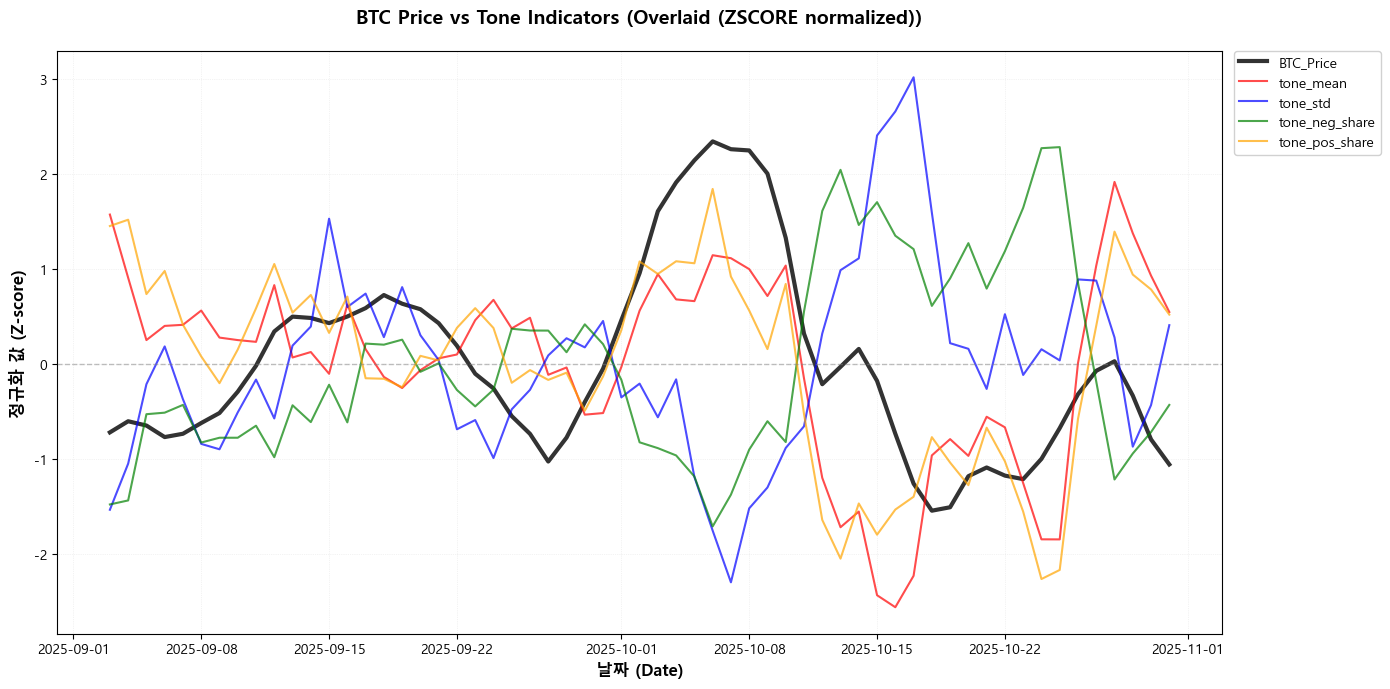


💡 그래프 해석:
   - 검은 굵은 선: BTC_Price (BTC 가격)
   - 색상 얇은 선: Tone 지표들
   - y=0 기준선: 평균 수준 (zscore 정규화)
   - 시각적으로 선행/동행 패턴을 확인 가능


In [30]:
# ============================================================
# 셀 27: 오버랩 라인 플롯 (발표용 1장)
# ============================================================

print("🎨 오버랩 시계열 라인 플롯 생성 중...\n")

# Figure 생성
fig, ax = plt.subplots(figsize=(14, 7))

# BTC_Price를 굵게 표시
ax.plot(df_norm.index, df_norm[price_col], 
        linewidth=3, label=price_col, color='black', alpha=0.8)

# Tone 지표들을 얇게 표시
colors = ['red', 'blue', 'green', 'orange']
for i, tone_col in enumerate(tone_cols):
    ax.plot(df_norm.index, df_norm[tone_col], 
            linewidth=1.5, label=tone_col, color=colors[i], alpha=0.7)

# y=0 기준선 표시 (zscore 정규화일 때 의미 있음)
if normalize == 'zscore':
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# 축 레이블 및 제목
ax.set_xlabel('날짜 (Date)', fontsize=12, fontweight='bold')
if normalize == 'zscore':
    ax.set_ylabel('정규화 값 (Z-score)', fontsize=12, fontweight='bold')
elif normalize == 'minmax':
    ax.set_ylabel('정규화 값 (Min-Max, 0~1)', fontsize=12, fontweight='bold')
else:
    ax.set_ylabel('값 (원본 스케일)', fontsize=12, fontweight='bold')

title_suffix = f" ({normalize.upper()} normalized)" if normalize != 'none' else " (원본 스케일)"
ax.set_title(f'BTC Price vs Tone Indicators (Overlaid{title_suffix})', 
             fontsize=14, fontweight='bold', pad=20)

# 격자선
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# 범례 위치 조정 (화면 밖 또는 best)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9, 
          bbox_to_anchor=(1.01, 1), borderaxespad=0)

# 레이아웃 조정
plt.tight_layout()

# ============================================================
# 이미지 저장
# ============================================================

os.makedirs(output_dir, exist_ok=True)
overlay_path = os.path.join(output_dir, 'overlay_tone_btc.png')

plt.savefig(
    overlay_path,
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

print(f"✅ 오버랩 라인 플롯 저장 완료!")
print(f"   저장 경로: {overlay_path}")
print(f"   해상도: 300 DPI")

# 화면에 표시
plt.show()

print("\n💡 그래프 해석:")
print(f"   - 검은 굵은 선: {price_col} (BTC 가격)")
print(f"   - 색상 얇은 선: Tone 지표들")
if normalize == 'zscore':
    print(f"   - y=0 기준선: 평균 수준 (zscore 정규화)")
print(f"   - 시각적으로 선행/동행 패턴을 확인 가능")


🎨 2×2 서브플롯 생성 중 (각 Tone 지표별 + BTC 오버랩)...

✅ 2×2 서브플롯 저장 완료!
   저장 경로: ./outputs\overlay_tone_btc_2x2.png
   해상도: 300 DPI


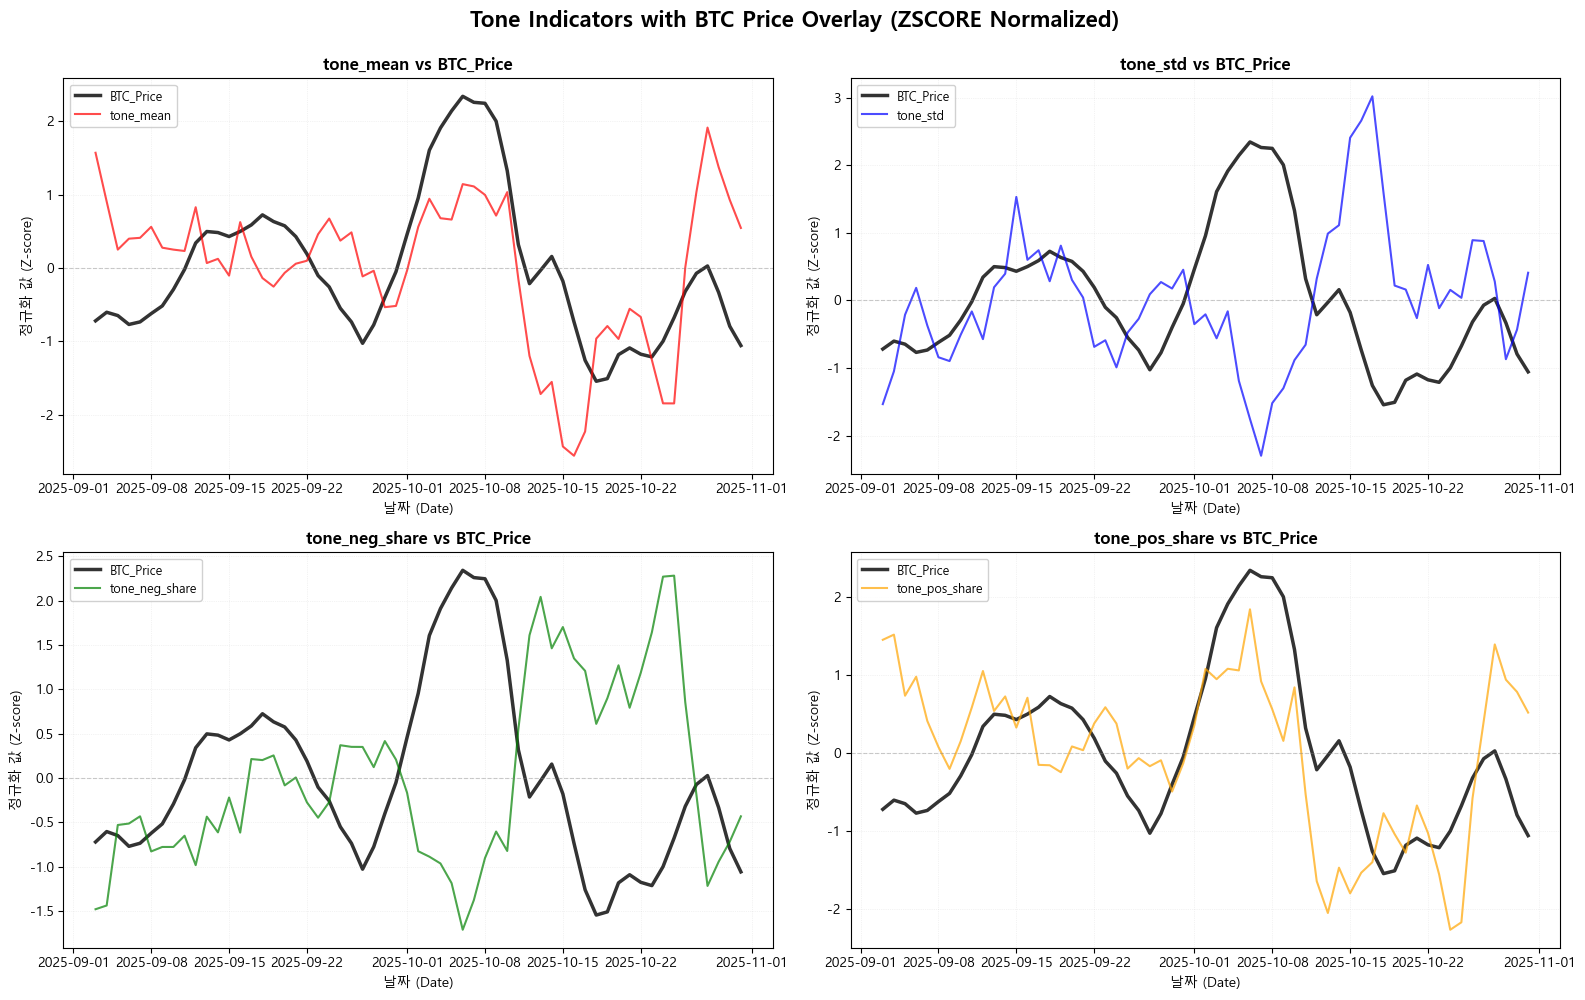


💡 그래프 해석:
   - 각 서브플롯: 개별 Tone 지표와 BTC_Price의 관계
   - 검은 굵은 선: BTC_Price (모든 플롯에 공통)
   - 색상 선: 각각의 Tone 지표
   - 동일한 정규화 스케일로 직접 비교 가능
   - 발표 시 가독성이 가장 좋은 형태

🎉 오버랩 시계열 그래프 생성 완료!

📁 생성된 파일:
   1. ./outputs\overlay_tone_btc.png
   2. ./outputs\overlay_tone_btc_2x2.png


In [31]:
# ============================================================
# 셀 28: 2×2 서브플롯 + BTC 오버랩 (가독성 최강, 발표 추천)
# ============================================================

print("🎨 2×2 서브플롯 생성 중 (각 Tone 지표별 + BTC 오버랩)...\n")

# Figure와 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 Tone 지표에 대해 서브플롯 생성
for i, tone_col in enumerate(tone_cols):
    ax = axes[i]
    
    # BTC_Price를 굵게 표시 (모든 서브플롯에 공통)
    ax.plot(df_norm.index, df_norm[price_col], 
            linewidth=2.5, label=price_col, color='black', alpha=0.8)
    
    # 해당 Tone 지표를 얇게 표시
    colors = ['red', 'blue', 'green', 'orange']
    ax.plot(df_norm.index, df_norm[tone_col], 
            linewidth=1.5, label=tone_col, color=colors[i], alpha=0.7)
    
    # y=0 기준선 표시 (zscore 정규화일 때)
    if normalize == 'zscore':
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.4)
    
    # 각 서브플롯 제목
    ax.set_title(f'{tone_col} vs {price_col}', fontsize=12, fontweight='bold')
    
    # 축 레이블
    ax.set_xlabel('날짜 (Date)', fontsize=10)
    if normalize == 'zscore':
        ax.set_ylabel('정규화 값 (Z-score)', fontsize=10)
    elif normalize == 'minmax':
        ax.set_ylabel('정규화 값 (0~1)', fontsize=10)
    else:
        ax.set_ylabel('값', fontsize=10)
    
    # 격자선
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # 범례
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)

# 전체 Figure 제목
title_suffix = f" ({normalize.upper()} Normalized)" if normalize != 'none' else ""
fig.suptitle(f'Tone Indicators with BTC Price Overlay{title_suffix}', 
             fontsize=16, fontweight='bold', y=0.995)

# 레이아웃 조정
plt.tight_layout()

# ============================================================
# 이미지 저장
# ============================================================

os.makedirs(output_dir, exist_ok=True)
subplot_path = os.path.join(output_dir, 'overlay_tone_btc_2x2.png')

plt.savefig(
    subplot_path,
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

print(f"✅ 2×2 서브플롯 저장 완료!")
print(f"   저장 경로: {subplot_path}")
print(f"   해상도: 300 DPI")

# 화면에 표시
plt.show()

print("\n💡 그래프 해석:")
print(f"   - 각 서브플롯: 개별 Tone 지표와 BTC_Price의 관계")
print(f"   - 검은 굵은 선: {price_col} (모든 플롯에 공통)")
print(f"   - 색상 선: 각각의 Tone 지표")
print(f"   - 동일한 정규화 스케일로 직접 비교 가능")
print(f"   - 발표 시 가독성이 가장 좋은 형태")

print("\n🎉 오버랩 시계열 그래프 생성 완료!")
print(f"\n📁 생성된 파일:")
print(f"   1. {overlay_path}")
print(f"   2. {subplot_path}")
